# Collaborative Filtering on ML-latest-small

## Part 1 - Data loading and EDA
> Collaborative Filtering on MovieLens Latest-small Part 1 - Downloading movielens latest small dataset and exploratory data analysis

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

In [ ]:
DOWNLOAD_DESTINATION_DIR = "/content/ml-latest-small"

ratings_path = os.path.join(DOWNLOAD_DESTINATION_DIR, 'ratings.csv')
ratings = pd.read_csv(
    ratings_path,
    sep=',',
    names=["userid", "itemid", "rating", "timestamp"],
    skiprows=1
)

movies_path = os.path.join(DOWNLOAD_DESTINATION_DIR, 'movies.csv')
movies = pd.read_csv(
    movies_path,
    sep=',',
    names=["itemid", "title", "genres"],
    encoding='latin-1',
    skiprows=1
)

In [ ]:
ratings.head()

,userid,itemid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,itemid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print("There are {} users and {} movies in this dataset."\
      .format(ratings.userid.nunique(),
              ratings.itemid.nunique()))

There are 610 users and 9724 movies in this dataset.


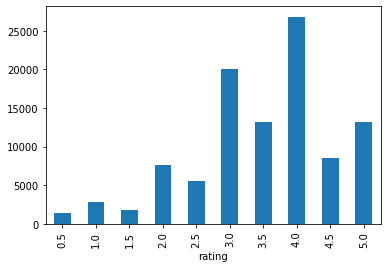

In [ ]:
# histogram of ratings
ratings.groupby('rating').size().plot(kind='bar');

Ratings range from $0.5$ to $5.0$, with a step of $0.5$. The above histogram presents the repartition of ratings in the dataset. the two most commun ratings are $4.0$ and $3.0$ and the less common ratings are $0.5$ and $1.5$

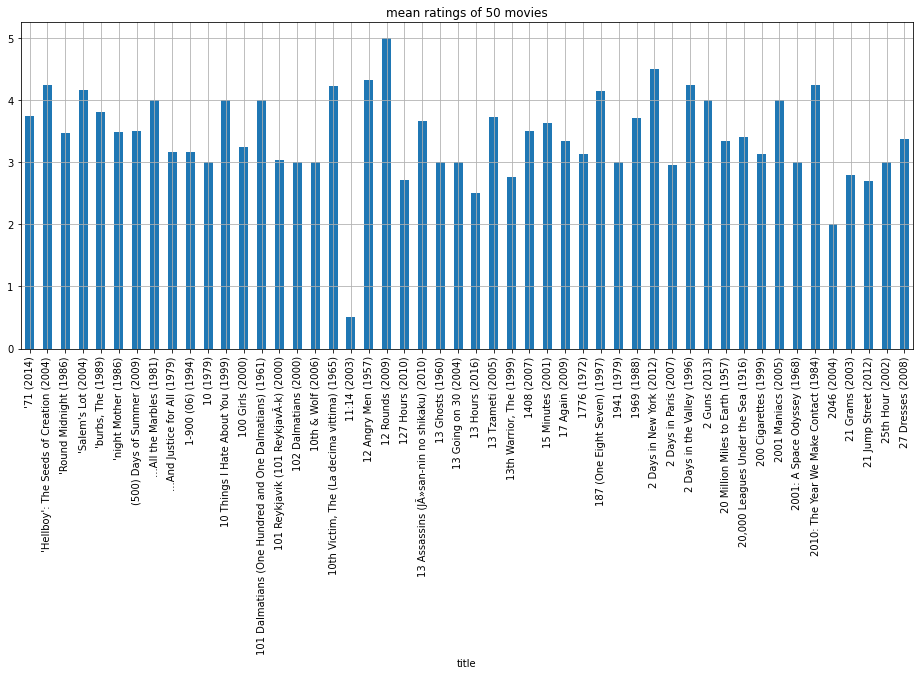

In [ ]:
# average rating of movies
movie_means = ratings.join(movies['title'], on='itemid').groupby('title').rating.mean()
movie_means[:50].plot(kind='bar', grid=True, figsize=(16,6), title="mean ratings of 50 movies");

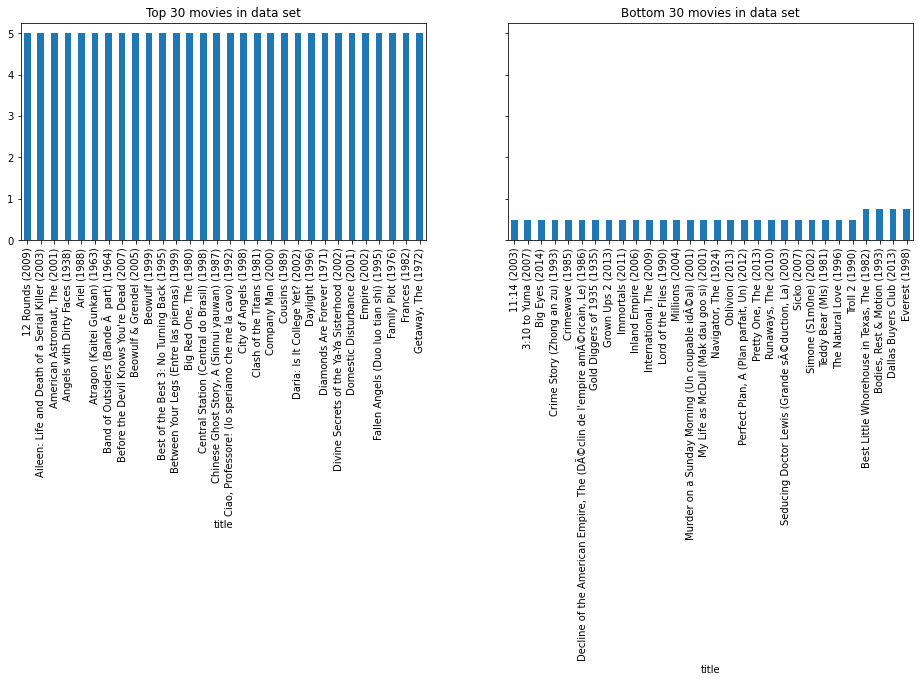

In [ ]:
# 30 most rated movies vs. 30 less rated movies
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4), sharey=True)
movie_means.nlargest(30).plot(kind='bar', ax=ax1, title="Top 30 movies in data set");
movie_means.nsmallest(30).plot(kind='bar', ax=ax2, title="Bottom 30 movies in data set");

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userid'].unique())
    items = sorted(ratings['itemid'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())

    return ratings, uencoder, iencoder

In [ ]:
# userids and itemids encoding
ratings, uencoder, iencoder = ids_encoder(ratings)

In [ ]:
# transform rating dataframe to matrix
def ratings_matrix(ratings):    
    return csr_matrix(pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum).fillna(0).values)    

R = ratings_matrix(ratings)

In [ ]:
R[:10,:10].todense()

matrix([[4. , 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 4. , 5. , 3. , 5. , 4. , 4. , 3. , 0. , 3. ],
        [4.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 2. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

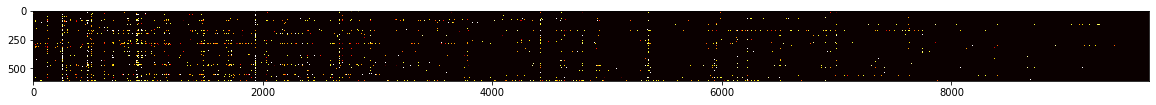

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(csr_matrix(R).todense(), cmap='hot', interpolation='nearest')
plt.show()

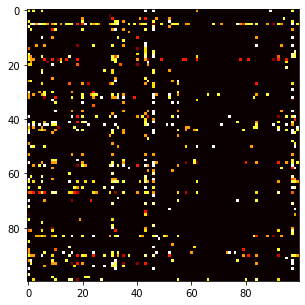

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(csr_matrix(R[:100,:100]).todense(), cmap='hot', interpolation='nearest')
plt.show()

## Part 2 - User-based method
> Collaborative Filtering on MovieLens Latest-small Part 2 - Finding recommendations using memory based user-user similarity method

### Download tools

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

### Import requirements
```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

from recsys.datasets import ml100k
from recsys.preprocessing import ids_encoder

import pandas as pd
import numpy as np
import zipfile

### Load MovieLen ratings

In [ ]:
ratings, movies = ml100k.load()

### userids and itemids encoding

In [ ]:
# create the encoder
ratings, uencoder, iencoder = ids_encoder(ratings)

### Transform rating dataframe to matrix

In [ ]:
def ratings_matrix(ratings):    
    return csr_matrix(pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum).fillna(0).values)    

R = ratings_matrix(ratings)

Memory based collaborative filtering (CF) also known as nearest neighbors based CF makes recommendation based on similar behavious of users and items. There are two types of memory based CF : <b>user-based</b> and <b>item-based</b> CF. Both of these algorithm usually proceed in three stages :

1. Similarity computation (between users or items)
2. Rating prediction (using ratings of similar users or items)
3. Top-N recommendation


### Idea

Let $u$ be the user for which we plan to make recommendations. 

1. Find other users whose past rating behavior is similar to that of $u$
2. Use their ratings on other items to predict what the current user will like

### Algorithm : user-to-user collaborative filtering

The entire process of user-to-user CF algorithm is described as follow <a href="https://romisatriawahono.net/lecture/rm/survey/information%20retrieval/Bobadilla%20-%20Recommender%20Systems%20-%202013.pdf">(J. Bobadilla et al. 2013)</a>: For an active user $u$,

<ol>
    <li> First identify the set $G_u$ of $k$ most similar users. $G_u$ is the group users similar to the active user $u$. The similarity between two users $u$ and $v$ can be measured by the cosine similarity measure as follows :

\begin{equation}
 w_{u,v}=\frac{\vec{r}_u \cdot \vec{r}_v}{\|\vec{r}_u\|_2 \ast \|\vec{r}_v\|_2} = \frac{\sum_{i\in I}r_{u,i}r_{v,i}}{\sqrt{\sum_{i\in I} (r_{u,i})^2}\sqrt{\sum_{i\in I} (r_{v,i})^2}}
\end{equation}

$w_{u,v}$ is the degree of similarity between users $u$ and $v$. This term is computed for all $v\in U$, where $U$ is the set of all users. There remains the question of how many neighbors to select. As experimented by <a href="https://dl.acm.org/doi/10.1145/3130348.3130372">(Herlocker et al. 1999)</a>, $k\in [20,50]$ is a reasonable starting point in many domains.
    </li>
    <li> Find the set $C$ of candidate items, purchased by the group and not purchased by the active user $u$. Candidate items have to be the most frequent items purchased by the group.
    </li>
    <li>Aggregate ratings of users in $G_u$ to make predictions for user $u$ on items he has not already purchased. Several aggregation approaches are often used such as <b>average, weighted sum, ajusted weighted sum</b>. By using weighted sum, the predicted rating of user $u$ on item $i$ denoted by $\hat{r}_{u,i}$ is computed as follow :

\begin{equation}
 \hat{r}_{u,i}=\bar{r}_u + \frac{\sum_{v\in G_u}(r_{v,i}-\bar{r}_v)\cdot w_{u,v}}{\sum_{v\in G_u}|w_{u,v}|}.
\end{equation}

Ratings of similar users are weighted by the corresponding similarity with the active user. Summation are made over all the users who have rated item $i$. Subtracting the user’s mean rating $\bar{r}_v$ compensates for differences in users’ use of the rating scale as some users will tend to give higher ratings than others <a href="https://dl.acm.org/doi/10.1561/1100000009">(Michael D. Ekstrand, <i>et al.</i> 2011)</a>. This prediction is made for all items $i \in C$ not purchased by user $u$.
    </li>
    <li>The Top-$N$ recommendations are obtained by choosing the $N$ items which provide most satisfaction to the user according to prediction.
    </li>
</ol>

#### Step 1. Identify $G_u$, the set of $k$ users similar to an active user $u$

To find the $k$ most similar users to $u$, we use the cosine similarity and compute $w_{u,v}$ for all $v\in U$. Fortunately, libraries such as <i>scikit-learn (sklearn)</i> are very useful for such tasks :

1. First of all, we create a nearest neighbors model with sklearn through the function ```create_model()```. This function creates and fit a nearest neighbors model with user's ratings. We can choose ```cosine``` or ```euclidian``` based similarity metric. ```n_neighbors=21``` define the number of neighbors to return. With $k=20$ neighbors, $|G_u|=21$ as $G_u$ contains $20$ similar users added to the active user $u$. That is why ```n_neighbors=21```. Each row $r_u$ of the rating matrix $R$ represents ratings of user $u$ on all items of the database. Missing ratings are replaced with $0.0$. 
```python
R[u,:] # uth row of the rating matrix R. Ratings of user u on all items in the database
```
2. Function ```nearest_neighbors()``` returns the knn users for each user.

In [ ]:
def create_model(rating_matrix, metric):
    """
    - create the nearest neighbors model with the corresponding similarity metric
    - fit the model
    """
    model = NearestNeighbors(metric=metric, n_neighbors=21, algorithm='brute')
    model.fit(rating_matrix)    
    return model

In [ ]:
def nearest_neighbors(rating_matrix, model):
    """    
    :param rating_matrix : rating matrix of shape (nb_users, nb_items)
    :param model : nearest neighbors model    
    :return
        - similarities : distances of the neighbors from the referenced user
        - neighbors : neighbors of the referenced user in decreasing order of similarities
    """    
    similarities, neighbors = model.kneighbors(rating_matrix)        
    return similarities[:, 1:], neighbors[:, 1:]

Let's call functions ```create_model()``` and ```nearest_neighbors()``` to respectively create the $k$-NN model and compute the nearest neighbors for a given user

In [ ]:
model = create_model(rating_matrix=R, metric='cosine') # we can also use the 'euclidian' distance
similarities, neighbors = nearest_neighbors(R, model)

#### Step 2. Find candidate items

The set $C$ of candidate items are the most frequent ones purchased by users in $G_u$ for an active user $u$ and not purchased by $u$.

Function ```find_candidate_items()``` : find items purchased by these similar users as well as their frequency. Note that the frequency of the items in the set $C$ can be computed by just counting the actual occurrence frequency of that items.

1. ```Gu_items``` : frequent items of $G_u$ in decreasing order of frequency.
2. ```active_items``` : items already purchased by the active user
3. ```candidates``` : frequent items of $G_u$ not purchased by the active user $u$

In [ ]:
def find_candidate_items(userid):
    """
    Find candidate items for an active user
    
    :param userid : active user
    :param neighbors : users similar to the active user        
    :return candidates : top 30 of candidate items
    """
    user_neighbors = neighbors[userid]
    activities = ratings.loc[ratings.userid.isin(user_neighbors)]
    
    # sort items in decreasing order of frequency
    frequency = activities.groupby('itemid')['rating'].count().reset_index(name='count').sort_values(['count'],ascending=False)
    Gu_items = frequency.itemid
    active_items = ratings.loc[ratings.userid == userid].itemid.to_list()
    candidates = np.setdiff1d(Gu_items, active_items, assume_unique=True)[:30]
        
    return candidates

#### Step 3. Rating prediction

Now it's time to predict what score the active user $u$ would have given to each of the top-30 candidate items.

To predict the score of $u$ on a candidate item $i$ ,we need :
1. Similarities between $u$ and all his neighbors $v \in G_u$ who rated item $i$ : function ```nearest_neighbors()``` returns similar users of a user as well as their corresponding similarities.
2. Normalized ratings of all $v \in G_u$ on item $i$. The normalized rating of user $v$ on item $i$ is defined by $r_{v,i}-\bar{r}_v$.

Next, let's compute the mean rating of each user and the normalized ratings for each item. The DataFrame ```mean``` contains mean rating for each user. With the mean rating of each user, we can add an extra column ```norm_rating``` to the ```ratings```'s DataFrame which can be accessed to make predictions.

In [ ]:
# mean ratings for each user
mean = ratings.groupby(by='userid', as_index=False)['rating'].mean()
mean_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='userid')

# normalized ratings for each items
mean_ratings['norm_rating'] = mean_ratings['rating'] - mean_ratings['rating_mean']

mean = mean.to_numpy()[:, 1]

In [ ]:
np_ratings = mean_ratings.to_numpy()

Let us define function ```predict``` that predict rating between user $u$ and item $i$. Recall that the prediction formula is defined as follow :

\begin{equation}
 \hat{r}_{u,i}=\bar{r}_u + \frac{\sum_{v\in G_u}(r_{v,i}-\bar{r}_v)\cdot w_{u,v}}{\sum_{v\in G_u}|w_{u,v}|}.
\end{equation}

In [ ]:
def predict(userid, itemid):
    """
    predict what score userid would have given to itemid.
    
    :param
        - userid : user id for which we want to make prediction
        - itemid : item id on which we want to make prediction
        
    :return
        - r_hat : predicted rating of user userid on item itemid
    """
    user_similarities = similarities[userid]
    user_neighbors = neighbors[userid]
    # get mean rating of user userid
    user_mean = mean[userid]
    
    # find users who rated item 'itemid'
    iratings = np_ratings[np_ratings[:, 1].astype('int') == itemid]
    
    # find similar users to 'userid' who rated item 'itemid'
    suri = iratings[np.isin(iratings[:, 0], user_neighbors)]
    
    # similar users who rated current item (surci)
    normalized_ratings = suri[:,4]
    indexes = [np.where(user_neighbors == uid)[0][0] for uid in suri[:, 0].astype('int')]
    sims = user_similarities[indexes]
    
    num = np.dot(normalized_ratings, sims)
    den = np.sum(np.abs(sims))
    
    if num == 0 or den == 0:
        return user_mean
    
    r_hat = user_mean + np.dot(normalized_ratings, sims) / np.sum(np.abs(sims))
    
    return r_hat

Now, we can make rating prediction for a given user on each item in his set of candidate items.

In [ ]:
def user2userPredictions(userid, pred_path):
    """
    Make rating prediction for the active user on each candidate item and save in file prediction.csv
    
    :param
        - userid : id of the active user
        - pred_path : where to save predictions
    """    
    # find candidate items for the active user
    candidates = find_candidate_items(userid)
    
    # loop over candidates items to make predictions
    for itemid in candidates:
        
        # prediction for userid on itemid
        r_hat = predict(userid, itemid)
        
        # save predictions
        with open(pred_path, 'a+') as file:
            line = '{},{},{}\n'.format(userid, itemid, r_hat)
            file.write(line)

In [ ]:
import sys

def user2userCF():
    """
    Make predictions for each user in the database.    
    """
    # get list of users in the database
    users = ratings.userid.unique()
    
    def _progress(count):
        sys.stdout.write('\rRating predictions. Progress status : %.1f%%' % (float(count/len(users))*100.0))
        sys.stdout.flush()
    
    saved_predictions = 'predictions.csv'    
    if os.path.exists(saved_predictions):
        os.remove(saved_predictions)
    
    for count, userid in enumerate(users):        
        # make rating predictions for the current user
        user2userPredictions(userid, saved_predictions)
        _progress(count)

In [ ]:
user2userCF()

Rating predictions. Progress status : 99.9%

#### Step 4. Top-N recommendation

Function ```user2userRecommendation()``` reads predictions for a given user and return the list of items in decreasing order of predicted rating.

In [ ]:
def user2userRecommendation(userid):
    """
    """
    # encode the userid
    uid = uencoder.transform([userid])[0]
    saved_predictions = 'predictions.csv'
    
    predictions = pd.read_csv(saved_predictions, sep=',', names=['userid', 'itemid', 'predicted_rating'])
    predictions = predictions[predictions.userid==uid]
    List = predictions.sort_values(by=['predicted_rating'], ascending=False)
    
    List.userid = uencoder.inverse_transform(List.userid.tolist())
    List.itemid = iencoder.inverse_transform(List.itemid.tolist())
    
    List = pd.merge(List, movies, on='itemid', how='inner')
    
    return List

In [ ]:
user2userRecommendation(212)

,userid,itemid,predicted_rating,title
0,212,483,4.871495,Casablanca (1942)
1,212,357,4.764547,One Flew Over the Cuckoo's Nest (1975)
2,212,50,4.660002,Star Wars (1977)
3,212,98,4.613636,"Silence of the Lambs, The (1991)"
4,212,64,4.550733,"Shawshank Redemption, The (1994)"
5,212,194,4.522336,"Sting, The (1973)"
6,212,174,4.521300,Raiders of the Lost Ark (1981)
7,212,134,4.414819,Citizen Kane (1941)
8,212,187,4.344531,"Godfather: Part II, The (1974)"
9,212,196,4.303696,Dead Poets Society (1989)


Let us make top n recommendation for a given user.

### Evaluation with Mean Absolute Error (MAE)

In [ ]:
from recsys.preprocessing import train_test_split, get_examples

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

def evaluate(x_test, y_test):
    print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
    preds = list(predict(u,i) for (u,i) in x_test)
    mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
    print('\nMAE :', mae)
    return mae

In [ ]:
evaluate(x_test, y_test)

Evaluate the model on 10000 test data ...

MAE : 0.7505910931068639


0.7505910931068639

### Summary

We have summarised all the steps of building the user-based collaborative filtering into a python class for further user. Click [UserToUser.py](https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/recsys/memories/UserToUser.py) for more details on the **UserToUser** class definition.

In [ ]:
from recsys.memories.UserToUser import UserToUser

# load ml100k ratings
ratings, movies = ml100k.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the user-based CF
usertouser = UserToUser(ratings, movies, metric='cosine')

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...


In [ ]:
# evaluate the user-based CF on the ml100k test data
usertouser.evaluate(x_test, y_test)

Evaluate the model on 10000 test data ...

MAE : 0.7505910931068639


0.7505910931068639

### Evaluation on the ML-1M dataset (this may take some time)

In [ ]:
from recsys.datasets import ml1m
from recsys.preprocessing import ids_encoder, get_examples, train_test_split
from recsys.memories.UserToUser import UserToUser

# load ml100k ratings
ratings, movies = ml1m.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

# create the user-based CF
usertouser = UserToUser(ratings, movies, k=20, metric='cosine')

# evaluate the user-based CF on the ml1m test data
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.732267005840993


0.732267005840993

### Limitations of user-based CF

1. <b> Sparsity </b> : In general, users interact with less than 20% of items. This leads the rating matrix to be highly sparse. For example, the movielen-100k contains 100k ratings from 943 users on 1682 items. The pourcentage of sparsity in this case is around $94\%$. A recommender system based on nearest neighbor algorithms may be unable to make any item recommendations for a particular user. As a result the accuracy of recommendations may be poor <a href="https://dl.acm.org/doi/10.1145/371920.372071">(Sarwar <i>et al.</i> 2001)</a>.

2. <b> Stability of user's ratings </b> : As a user rates and re-rates items, their rating vector will change along with their similarity to other users. A user’s neighborhood is determined not only by their ratings but also by the ratings of other users, so their neighborhood can change as a result of new ratings supplied by any user in the system <a href="https://dl.acm.org/doi/10.1561/1100000009">(Michael D. Ekstrand, <i>et al.</i> 2011)</a>.

3. <b> Scalability </b> : Due to the non-stability of users ratings, finding similar users in advance is complicated. For this reason, most user-based CF systems find neighborhoods each time predictions or recommendations are needed. However, these are huge computations that grows with both the number of users and the number of items. With millions of users and items, a typical web-based recommender system running existing algorithms will suffer serious scalability concerns <a href="https://dl.acm.org/doi/10.1145/371920.372071">(Sarwar <i>et al.</i> 2001)</a>, <a href="https://dl.acm.org/doi/10.1561/1100000009">(Michael D. Ekstrand, <i>et al.</i> 2011)</a>.

## Part 3 - Item-based method
> Collaborative Filtering on MovieLens Latest-small Part 3 - Finding recommendations using memory based item-item similarity method

### Idea
Let $u$ be the active user and $i$ the referenced item
1. If $u$ liked items similar to $i$, he will probably like item $i$.
2. If he hated or disliked items similar to $i$, he will also hate item $i$.

The idea is therefore to look at how an active user $u$ rated items similar to $i$ to know how he would have rated item $i$

### Advantages over user-based CF

1. <b> Stability </b> : Items ratings are more stable than users ratings. New ratings on items are unlikely to significantly change the similarity between two items, particularly when the items have many ratings <a href="https://dl.acm.org/doi/10.1561/1100000009">(Michael D. Ekstrand, <i>et al.</i> 2011)</a>. 
2. <b> Scalability </b> : with stable item's ratings, it is reasonable to pre-compute similarities between items in an item-item similarity matrix (similarity between items can be computed offline). This will reduce the scalability concern of the algorithm. <a href="https://dl.acm.org/doi/10.1145/371920.372071">(Sarwar <i>et al.</i> 2001)</a>, <a href="https://dl.acm.org/doi/10.1561/1100000009">(Michael D. Ekstrand, <i>et al.</i> 2011)</a>.

### Algorithm : item-to-item collaborative filtering

The algorithm that defines item-based CF is described as follow <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.449.1171&rep=rep1&type=pdf">(B. Sarwar et al. 2001)</a><a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.554.1671&rep=rep1&type=pdf">(George Karypis 2001)</a> :

<ol>
    <li>
        First identify the $k$ most similar items for each item in the catalogue and record the corresponding similarities. To compute similarity between two items we can user the <i>Adjusted Cosine Similarity</i> that has proven to be more efficient than the basic <i>Cosine similarity measure</i> used for user-based collaborative as described in <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.449.1171&rep=rep1&type=pdf">(B. Sarwar et al. 2001)</a>. The Adjusted Cosine distance between two items $i$ and $j$ is computed as follow

\begin{equation}
 w_{i,j}= \frac{\sum_{u\in U}(r_{u,i}-\bar{r}_u)(r_{u,j}-\bar{r}_u)}{\sqrt{\sum_{u\in U} (r_{u,i}-\bar{r}_u)^2}\sqrt{\sum_{u\in U} (r_{u,j}-\bar{r}_u)^2}}
\end{equation}

$w_{i,j}$ is the degree of similarity between items $i$ and $j$. This term is computed for all users $u\in U$, where $U$ is the set of users that rated both items $i$ and $j$. Let's denote by $S^{(i)}$ the set of the $k$ most similar items to item $i$.
    </li>    
    <li> To produce top-N recommendations for a given user $u$ that has already purchased a set $I_u$ of items, do the following :
<ul>
    <li> Find the set $C$ of candidate items by taking the union of all $S^{(i)}, \forall i\in I_u$ and removing each of the items in the set $I_u$.
\begin{equation}
 C = \bigcup_{i\in I_u}\{S^{(i)}\}\smallsetminus I_u
\end{equation}
    </li>
    <li>
        $\forall c\in C$, compute similarity between c and the set $I_u$ as follows:
\begin{equation}
 w_{c,I_u} = \sum_{i\in I_u} w_{c,i}, \forall c \in C
\end{equation}
    </li>
    <li>
        Sort items in $C$ in decreasing order of $w_{c,I_u}, \forall c \in C$, and return the first $N$ items as the Top-N recommendation list.
    </li>
</ul>    
    </li>
</ol>

Before returning the first $N$ items as top-N recommendation list, we can make predictions about what user $u$ would have given to each items in the top-N recommendation list, rearrange the list in descending order of predicted ratings and return the rearranged list as the final recommendation list. Rating prediction for item-based CF is given by the following formular <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.449.1171&rep=rep1&type=pdf">(B. Sarwar et al. 2001)</a>:

\begin{equation}
 \hat{r}_{u,i}=\frac{\sum_{i\in S^{(i)}}r_{u,j}\cdot w_{i,j}}{\sum_{j\in S^{(i)}}|w_{i,j}|}
\end{equation}

#### Import useful requirements

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

#### Import requirements

```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

from recsys.datasets import ml1m, ml100k
from recsys.preprocessing import ids_encoder

import pandas as pd
import numpy as np
import os
import sys

#### Load ratings

In [ ]:
ratings, movies = ml100k.load()

#### userids and itemids encoding

In [ ]:
# create the encoder
ratings, uencoder, iencoder = ids_encoder(ratings)

Let's implements the item-based collaborative filtering algorithm described above

#### Step 1. Find similarities for each of the items

To compute similarity between two items $i$ and $j$, we need to :

1. find all users who rated both of them,
2. Normalize their ratings on items $i$ and $j$
3. Apply the cosine metric to the normalized ratings to compute similarity between $i$ and $j$

Function ```normalize()``` process the rating dataframe to normalize ratings of all users

In [ ]:
def normalize():
    # compute mean rating for each user
    mean = ratings.groupby(by='userid', as_index=False)['rating'].mean()
    norm_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='userid')
    
    # normalize each rating by substracting the mean rating of the corresponding user
    norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    return mean.to_numpy()[:, 1], norm_ratings

In [ ]:
mean, norm_ratings = normalize()
np_ratings = norm_ratings.to_numpy()
norm_ratings.head()

,userid,itemid,rating,rating_mean,norm_rating
0,0,0,5,3.610294,1.389706
1,0,1,3,3.610294,-0.610294
2,0,2,4,3.610294,0.389706
3,0,3,3,3.610294,-0.610294
4,0,4,3,3.610294,-0.610294


now that each rating has been normalized, we can represent each item by a vector of its normalized ratings

In [ ]:
def item_representation(ratings):    
    return csr_matrix(
        pd.crosstab(ratings.itemid, ratings.userid, ratings.norm_rating, aggfunc=sum).fillna(0).values
    )

In [ ]:
R = item_representation(norm_ratings)

Let's build and fit our $k$-NN model using sklearn

In [ ]:
def create_model(rating_matrix, k=20, metric="cosine"):
    """
    :param R : numpy array of item representations
    :param k : number of nearest neighbors to return    
    :return model : our knn model
    """    
    model = NearestNeighbors(metric=metric, n_neighbors=k+1, algorithm='brute')
    model.fit(rating_matrix)    
    return model

##### Similarities computation

Similarities between items can be measured with the *Cosine* or *Eucliedian* distance. The ***NearestNeighbors*** class from the sklearn library simplifies the computation of neighbors. We just need to specify the metric (e.g. cosine or euclidian) that will be used to compute similarities.

The above method, ```create_model```, creates the kNN model and the following ```nearest_neighbors``` method uses the created model to kNN items. It returns nearest neighbors as well as similarities measures for each items.

```nearest_neighbors``` returns :
- ```similarities``` : numpy array of shape $(n,k)$
- ```neighbors``` : numpy array of shape $(n,k)$

where $n$ is the total number of items and $k$ is the number of neighbors to return, specified when creating the kNN model.

In [ ]:
def nearest_neighbors(rating_matrix, model):
    """
    compute the top n similar items for each item.    
    :param rating_matrix : items representations
    :param model : nearest neighbors model    
    :return similarities, neighbors
    """    
    similarities, neighbors = model.kneighbors(rating_matrix)    
    return similarities[:,1:], neighbors[:,1:]

##### Ajusted Cosine Similarity
In the context of item-based collaborative filtering, the adjusted cosine similarity has shown to be more efficient that the cosine or the euclidian distance. Here is the formular to compute the adjusted cosine weight between two items $i$ and $j$ :

\begin{equation}
 w_{i,j}= \frac{\sum_{u\in U}(r_{u,i}-\bar{r}_u)(r_{u,j}-\bar{r}_u)}{\sqrt{\sum_{u\in U} (r_{u,i}-\bar{r}_u)^2}\sqrt{\sum_{u\in U} (r_{u,j}-\bar{r}_u)^2}}.
\end{equation}

This term is computed for all users $u\in U$, where $U$ is the set of users that rated both items $i$ and $j$. Since the *sklearn* library do not directly implement the adjusted cosine similarity metric, we will implement it with the method ```adjusted_cosine```, with some helper function :

- ```save_similarities``` : since the computation of the adjusted cosine similarity is time consuming, around 5 mins for the ml100k dataset, we use this method to save the computed similarities for lated usage.
- ```load_similarities``` : load the saved similarities
- ```cosine``` : cosine distance between two vectors.

In [ ]:
def save_similarities(similarities, neighbors, dataset_name):    
    base_dir = 'recsys/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(save_dir, exist_ok=True)    
    similarities_file_name = os.path.join(save_dir, 'similarities.npy')
    neighbors_file_name = os.path.join(save_dir, 'neighbors.npy')    
    try:
        np.save(similarities_file_name, similarities)
        np.save(neighbors_file_name, neighbors)        
    except ValueError as error:
        print(f"An error occured when saving similarities, due to : \n ValueError : {error}")

        
def load_similarities(dataset_name, k=20):
    base_dir = 'recsys/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)    
    similiraties_file = os.path.join(save_dir, 'similarities.npy')
    neighbors_file = os.path.join(save_dir, 'neighbors.npy')    
    similarities = np.load(similiraties_file)
    neighbors = np.load(neighbors_file)    
    return similarities[:,:k], neighbors[:,:k]


def cosine(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def adjusted_cosine(np_ratings, nb_items, dataset_name):
    similarities = np.zeros(shape=(nb_items, nb_items))
    similarities.fill(-1)
    
    def _progress(count):
        sys.stdout.write('\rComputing similarities. Progress status : %.1f%%' % (float(count / nb_items)*100.0))
        sys.stdout.flush()
        
    items = sorted(ratings.itemid.unique())    
    for i in items[:-1]:
        for j in items[i+1:]:            
            scores = np_ratings[(np_ratings[:, 1] == i) | (np_ratings[:, 1] == j), :]
            vals, count = np.unique(scores[:,0], return_counts = True)
            scores = scores[np.isin(scores[:,0], vals[count > 1]),:]

            if scores.shape[0] > 2:
                x = scores[scores[:, 1].astype('int') == i, 4]
                y = scores[scores[:, 1].astype('int') == j, 4]
                w = cosine(x, y)

                similarities[i, j] = w
                similarities[j, i] = w
        _progress(i)
    _progress(nb_items)
    
    # get neighbors by their neighbors in decreasing order of similarities
    neighbors = np.flip(np.argsort(similarities), axis=1)
    
    # sort similarities in decreasing order
    similarities = np.flip(np.sort(similarities), axis=1)
    
    # save similarities to disk
    save_similarities(similarities, neighbors, dataset_name=dataset_name) 
    
    return similarities, neighbors

now, we can call the ```adjusted_cosine``` function to compute and save items similarities and neighbors based on the adjusted cosine metric. 

uncomment the two lines of the following cell to compute the adjusted cosine between all items. As we have already run the next cell before, we will just load the precomputed similarities for further use.

In [ ]:
# nb_items = ratings.itemid.nunique()
# similarities, neighbors = adjusted_cosine(np_ratings, nb_items=nb_items, dataset_name='ml100k')

Among the following similarity metrics, choose the one you wish to use for the item-based collaborative filtering :

- **euclidian** or **cosine** : choose *euclidian* or *cosine* to initialise the similarity model through the sklearn library.
- **adjusted_cosine** : choose the *adjusted_cosine* metric to load similarities computed and saved through the ```adjusted_cosine``` function.

In this case, we will use the *adjusted_cosine* metric.

In [ ]:
# metric : choose among [cosine, euclidean, adjusted_cosine]

metric = 'adjusted_cosine'

if metric == 'adjusted_cosine':
    similarities, neighbors = load_similarities('ml100k')
else:
    model = create_model(R, k=21, metric=metric)
    similarities, neighbors = nearest_neighbors(R, model)

In [ ]:
print('neighbors shape : ', neighbors.shape)
print('similarities shape : ', similarities.shape)

neighbors shape :  (1682, 20)
similarities shape :  (1682, 20)


```neighbors``` and ```similarities``` are numpy array, were each entries are list of 20 neighbors with their corresponding similarities

#### Step 2. Top N recommendation for a given user

Top-N recommendations are made for example for a user $u$ who has already rated a set of items $I_u$

##### 2.a- Finding candidate items

To find candidate items for user $u$, we need to :

1. Find the set $I_u$ of items already rated by user $u$,
2. Take the union of similar items as $C$ for all items in $I_u$
3. exclude from the set $C$ all items in $I_u$, to avoid recommend to a user items he has already purchased.

These are done in function ```candidate_items()```

In [ ]:
def candidate_items(userid):
    """
    :param userid : user id for which we wish to find candidate items    
    :return : I_u, candidates
    """
    
    # 1. Finding the set I_u of items already rated by user userid
    I_u = np_ratings[np_ratings[:, 0] == userid]
    I_u = I_u[:, 1].astype('int')
    
    # 2. Taking the union of similar items for all items in I_u to form the set of candidate items
    c = set()
        
    for iid in I_u:    
        # add the neighbors of item iid in the set of candidate items
        c.update(neighbors[iid])
        
    c = list(c)
    # 3. exclude from the set C all items in I_u.
    candidates = np.setdiff1d(c, I_u, assume_unique=True)
    
    return I_u, candidates

In [ ]:
test_user = uencoder.transform([1])[0]
i_u, u_candidates = candidate_items(test_user)

In [ ]:
print('number of items purchased by user 1 : ', len(i_u))
print('number of candidate items for user 1 : ', len(u_candidates))

number of items purchased by user 1 :  272
number of candidate items for user 1 :  893


##### 2.b- Find similarity between each candidate item and the set $I_u$

In [ ]:
def similarity_with_Iu(c, I_u):
    """
    compute similarity between an item c and a set of items I_u. For each item i in I_u, get similarity between 
    i and c, if c exists in the set of items similar to itemid.    
    :param c : itemid of a candidate item
    :param I_u : set of items already purchased by a given user    
    :return w : similarity between c and I_u
    """
    w = 0    
    for iid in I_u :        
        # get similarity between itemid and c, if c is one of the k nearest neighbors of itemid
        if c in neighbors[iid] :
            w = w + similarities[iid, neighbors[iid] == c][0]    
    return w

##### 2.c- Rank candidate items according to their similarities to $I_u$

In [ ]:
def rank_candidates(candidates, I_u):
    """
    rank candidate items according to their similarities with i_u    
    :param candidates : list of candidate items
    :param I_u : list of items purchased by the user    
    :return ranked_candidates : dataframe of candidate items, ranked in descending order of similarities with I_u
    """
    
    # list of candidate items mapped to their corresponding similarities to I_u
    sims = [similarity_with_Iu(c, I_u) for c in candidates]
    candidates = iencoder.inverse_transform(candidates)    
    mapping = list(zip(candidates, sims))
    
    ranked_candidates = sorted(mapping, key=lambda couple:couple[1], reverse=True)    
    return ranked_candidates

### Putting all together

Now that we defined all functions necessary to build our item to item top-N recommendation, let's define function ```item2item_topN()``` that makes top-$N$ recommendations for a given user 

In [ ]:
def topn_recommendation(userid, N=30):
    """
    Produce top-N recommendation for a given user    
    :param userid : user for which we produce top-N recommendation
    :param n : length of the top-N recommendation list    
    :return topn
    """
    # find candidate items
    I_u, candidates = candidate_items(userid)
    
    # rank candidate items according to their similarities with I_u
    ranked_candidates = rank_candidates(candidates, I_u)
    
    # get the first N row of ranked_candidates to build the top N recommendation list
    topn = pd.DataFrame(ranked_candidates[:N], columns=['itemid','similarity_with_Iu'])    
    topn = pd.merge(topn, movies, on='itemid', how='inner')    
    return topn

In [ ]:
topn_recommendation(test_user)

,itemid,similarity_with_Iu,title
0,1356,52.867173,Ed's Next Move (1996)
1,1189,50.362199,Prefontaine (1997)
2,1516,31.133267,"Wedding Gift, The (1994)"
3,1550,31.031738,Destiny Turns on the Radio (1995)
4,1554,27.364494,Safe Passage (1994)
5,1600,27.287712,Guantanamera (1994)
6,1223,26.631850,King of the Hill (1993)
7,1388,26.624397,Gabbeh (1996)
8,766,26.590175,Man of the Year (1995)
9,691,26.461802,Dark City (1998)


This dataframe represents the top N recommendation list a user. These items are sorted in decreasing order of similarities with $I_u$.

**Observation** : The recommended items are the most similar to the set $I_u$ of items already purchased by the user.

### Top N recommendation with predictions

Before recommending the previous list to the user, we can go further and predict the ratings the user would have given to each of these items, sort them in descending order of prediction and return the reordered list as the new top N recommendation list.

#### Rating prediction

As stated earlier, the predicted rating $\hat{r}_{u,i}$ for a given user $u$ on an item $i$ is obtained by aggregating ratings given by $u$ on items similar to $i$ as follows:

\begin{equation}
 \hat{r}_{u,i}=\frac{\sum_{j\in S^{(i)}}r_{u,j}\cdot w_{i,j}}{\sum_{j\in S^{(i)}}|w_{i,j}|}
\end{equation}

In [ ]:
def predict(userid, itemid):
    """
    Make rating prediction for user userid on item itemid    
    :param userid : id of the active user
    :param itemid : id of the item for which we are making prediction        
    :return r_hat : predicted rating
    """
    
    # Get items similar to item itemid with their corresponding similarities
    item_neighbors = neighbors[itemid]
    item_similarities = similarities[itemid]
    
    # get ratings of user with id userid
    uratings = np_ratings[np_ratings[:, 0].astype('int') == userid]
    
    # similar items rated by item the user of i
    siru = uratings[np.isin(uratings[:, 1], item_neighbors)]
    scores = siru[:, 2]
    indexes = [np.where(item_neighbors == iid)[0][0] for iid in siru[:,1].astype('int')]    
    sims = item_similarities[indexes]
    
    dot = np.dot(scores, sims)
    som = np.sum(np.abs(sims))

    if dot == 0 or som == 0:
        return mean[userid]
    
    return dot / som

Now let's use our ```predict()``` function to predict what ratings the user would have given to the previous top-$N$ list and return the reorganised list (in decreasing order of predictions) as the new top-$N$ list

In [ ]:
def topn_prediction(userid):
    """
    :param userid : id of the active user    
    :return topn : initial topN recommendations returned by the function item2item_topN
    :return topn_predict : topN recommendations reordered according to rating predictions
    """
    # make top N recommendation for the active user
    topn = topn_recommendation(userid)
    
    # get list of items of the top N list
    itemids = topn.itemid.to_list()
    
    predictions = []
    
    # make prediction for each item in the top N list
    for itemid in itemids:
        r = predict(userid, itemid)
        
        predictions.append((itemid,r))
    
    predictions = pd.DataFrame(predictions, columns=['itemid','prediction'])
    
    # merge the predictions to topN_list and rearrange the list according to predictions
    topn_predict = pd.merge(topn, predictions, on='itemid', how='inner')
    topn_predict = topn_predict.sort_values(by=['prediction'], ascending=False)
    
    return topn, topn_predict

Now, let's make recommendation for user 1 and compare the two list

In [ ]:
topn, topn_predict = topn_prediction(userid=test_user)

In [ ]:
topn_predict

,itemid,similarity_with_Iu,title,prediction
7,1388,26.624397,Gabbeh (1996),4.666667
18,359,22.973658,"Assignment, The (1997)",4.600000
4,1554,27.364494,Safe Passage (1994),4.500000
14,1538,24.492453,All Over Me (1997),4.500000
27,1448,20.846909,My Favorite Season (1993),4.490052
29,1375,20.627152,"Cement Garden, The (1993)",4.333333
26,1466,21.063269,Margaret's Museum (1995),4.271915
2,1516,31.133267,"Wedding Gift, The (1994)",4.000000
23,1467,21.861203,"Saint of Fort Washington, The (1993)",4.000000
21,1537,22.061914,Cosi (1996),4.000000


As you will have noticed, the two lists are sorted in different ways. The second list is organized according to the predictions made for the user.

<b>Note</b>: When making predictions for user $u$ on item $i$, user $u$ may not have rated any of the $k$ most similar items to i. In this case, we consider the mean rating of $u$ as the predicted value.

### Evaluation with Mean Absolute Error

In [ ]:
from recsys.preprocessing import train_test_split, get_examples

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

def evaluate(x_test, y_test):
    print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
    preds = list(predict(u,i) for (u,i) in x_test)
    mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
    print('\nMAE :', mae)
    return mae

In [ ]:
evaluate(x_test, y_test)

Evaluate the model on 10000 test data ...

MAE : 0.672389703640273


0.672389703640273

### Summary

As with the User-based CF, we have also summarised the Item-based CF into the python class [ItemToItem](https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/recsys/memories/ItemToItem.py). 

##### ItemToItem : usage

In [ ]:
from recsys.memories.ItemToItem import ItemToItem
from recsys.preprocessing import ids_encoder, train_test_split, get_examples
from recsys.datasets import ml100k

# load data
ratings, movies = ml100k.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

##### Instanciate the ItemToItem CF

Parameters :
- ```k``` : number of neighbors to consider for each item
- ```metric``` : metric to use when computing similarities : let's use **cosine**
- ```dataset_name``` : in this example, we use the ml100k dataset

In [ ]:
# create the Item-based CF
item2item = ItemToItem(ratings, movies, k=20, metric='cosine', dataset_name='ml100k')

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...


In [ ]:
# evaluate the algorithm on test dataset
item2item.evaluate(x_test, y_test)

Evaluate the model on 10000 test data ...

MAE : 0.507794195659005


0.507794195659005

##### Evaluate the Item-based CF on the ML-1M dataset

In [ ]:
from recsys.memories.ItemToItem import ItemToItem
from recsys.preprocessing import ids_encoder, train_test_split, get_examples
from recsys.datasets import ml1m

# load data
ratings, movies = ml1m.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

# create the Item-based CF
item2item = ItemToItem(ratings, movies, k=20, metric='cosine', dataset_name='ml1m')

# evaluate the algorithm on test dataset
print("=========================")
item2item.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.42514728655396045


0.42514728655396045

### Model based CF

**User-based** and **Item-based CF** are memory based algorithms. They directly act on the user-item interactions to compute recommendation. To the contrary, model-based algorithms are mathematical models trained on the user-item interactions and used to predict recommendation.

We will start with the SVD (Singular Value Decomposition) algorithm.

## Part 4 - SVD method
> Collaborative Filtering on MovieLens Latest-small Part 4 - Finding recommendations using model based singular value decomposition (SVD) method.

Due to the high level sparsity of the rating matrix $R$, **user-based** and **item-based** collaborative filtering suffer from **data sparsity** and **scalability**. These cause user and item-based collaborative filtering to be less effective and highly affect their performences. 

To address the high level sparsity problem, [Sarwar et al. (2000)](http://files.grouplens.org/papers/webKDD00.pdf) proposed to reduce the dimensionality of the rating $R$ using the *Singular Value Decomposition (SVD)* algorithm.

---

### How do SVD works ?

As described is Figure 1, SVD factors the rating matrix $R$ of size $m\times n$ into three matrices $P$, $\Sigma$ and $Q$ as follows :

\begin{equation}
R = P\Sigma Q^{\top}.
\end{equation}

Here, $P$ and $Q$ are two orthogonal matrices of size $m\times \hat{k}$ and $n\times \hat{k}$ respectively and $\Sigma$ is a diagonal matrix of size $ \hat{k}\times \hat{k}$ (with $ \hat{k}$ the rank of matrix $R$) having all singular values of the rating matrix R as its diagonal entries ([Billsus and Pazzani, 1998](https://www.ics.uci.edu/~pazzani/Publications/MLC98.pdf), [Sarwar et al. (2000)](http://files.grouplens.org/papers/webKDD00.pdf)).

![](https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/recsys/img/svd.png?raw=1)
<center> <b>Figure 1</b> : Singular value decomposition of rating matrix $R$ </center>

After having choosen $k$, the dimension of factors that will represent users and items, we can truncate matrix $\Sigma$ by only retaining its $k$ largest singular values to yield $\Sigma_k$ and reduce matrices $P$ and $Q$ accordingly to obtain $P_k$ and $Q_k$. The rating matrix will then be estimated as 

\begin{equation}
R_k = P_k\Sigma_k Q_k^{\top}.
\end{equation}

Once these matrices are known, they can be used for rating predictions ant top-N recommendations. $P_k\Sigma_k^{\frac{1}{2}}$ represents the latent space of users and $\Sigma_k^{\frac{1}{2}}Q_k^{\top}$ the latent space of items. Rating prediction for user $u$ on $i$ is done by the following formular

\begin{equation}
\hat{R}_{u,i} = \begin{bmatrix}P_k\Sigma_k^{\frac{1}{2}}\end{bmatrix}_u \begin{bmatrix}\Sigma_k^{\frac{1}{2}}Q_k^{\top}\end{bmatrix}_i.
\end{equation}

Before applying SVD, its important to fill in missing values of the rating matrix $R$. [Sarwar et al. (2000)](http://files.grouplens.org/papers/webKDD00.pdf) found the item’s mean rating to be useful default values. The user's average rating can also be used but the former shown better performances. Adding ratings normalization by subtracting the user mean rating or other baseline predictor can improve accuracy.

---

### SVD algorithm

> 1. Factor the normalize rating matrix $R_{norm}$ to obtain matrices $P$, $\Sigma$ and $Q$
> 2. Reduce $\Sigma$ to dimension $k$ to obtain $\Sigma_k$
> 3. Compute the square-root of $\Sigma_k$ to obtain $\Sigma_k^{\frac{1}{2}}$
> 4. Compute the resultant matrices $P_k\Sigma_k^{\frac{1}{2}}$ and $\Sigma_k^{\frac{1}{2}}Q_k^{\top}$ that will be used to compute recommendation scores for any user and items.

---

### Implementation details

SVD can easily be implemented using python library such as ```numpy```, ```scipy``` or ```sklearn```. As described by Andrew Ng in his [Machine Learning course](https://www.coursera.org/learn/machine-learning/lecture/CEXN0/vectorization-low-rank-matrix-factorization), it's not recommended to implement the standard SVD by ourselves. Instead, we can take advantage of matrix libraries (such as those listed before) that are optimized for matrix computations and vectorization.

Now let's implement the SVD collaborative filtering

### Download useful tools

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

### Import requirements

```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [ ]:
from recsys.datasets import mlLastedSmall, ml100k, ml1m
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

import pandas as pd
import numpy as np
import os

### Loading movielen ratings

In [ ]:
ratings, movies = mlLastedSmall.load()

Let's see how our rating matrix looks like

In [ ]:
pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum)

itemid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can observe that our rating matrix has many of unobserved value. However, as we described earlier, the SVD algorithm requires that all inputs in the matrix must be defined. Let's initialize the unobserved ratings with item's average that led to better performances compared to the user's average or even a null initialization ([Sarwar et al. (2000)](http://files.grouplens.org/papers/webKDD00.pdf)).

We can go further and subtrat from each rating the corresponding user mean to normalize the data. This helps to improve the accuracy of the model.

In [ ]:
# get user's mean rating
umean = ratings.groupby(by='userid')['rating'].mean()

In [ ]:
def rating_matrix(ratings):
    """
    1. Fill NaN values with item's average ratings
    2. Normalize ratings by subtracting user's mean ratings
    
    :param ratings : DataFrame of ratings data
    :return
        - R : Numpy array of normalized ratings
        - df : DataFrame of normalized ratings
    """
    
    # fill missing values with item's average ratings
    df = pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum)
    df = df.fillna(df.mean(axis=0))
    
    # subtract user's mean ratings to normalize data
    df = df.subtract(umean, axis=0)
    
    # convert our dataframe to numpy array
    R = df.to_numpy()
    
    return R, df

# generate rating matrix by calling function rating_matrix
R, df = rating_matrix(ratings)

$R$ is our final rating matrix. This is how the final rating matrix looks like

In [ ]:
df

itemid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,-0.934561,-0.366379,-2.009236,-1.294951,-0.366379,-1.181194,-1.491379,-1.241379,-0.870167,...,-0.866379,-1.366379,-0.366379,-0.366379,-0.866379,-0.366379,-0.866379,-0.866379,-0.866379,-0.366379
2,-0.027346,-0.516458,-0.688660,-1.591133,-0.876847,-0.002197,-0.763091,-1.073276,-0.823276,-0.452064,...,-0.448276,-0.948276,0.051724,0.051724,-0.448276,0.051724,-0.448276,-0.448276,-0.448276,0.051724
3,1.485033,0.995921,0.823718,-0.078755,0.635531,1.510181,0.749288,0.439103,0.689103,1.060315,...,1.064103,0.564103,1.564103,1.564103,1.064103,1.564103,1.064103,1.064103,1.064103,1.564103
4,0.365375,-0.123737,-0.295940,-1.198413,-0.484127,0.390523,-0.370370,-0.680556,-0.430556,-0.059343,...,-0.055556,-0.555556,0.444444,0.444444,-0.055556,0.444444,-0.055556,-0.055556,-0.055556,0.444444
5,0.363636,-0.204545,-0.376748,-1.279221,-0.564935,0.309715,-0.451178,-0.761364,-0.511364,-0.140152,...,-0.136364,-0.636364,0.363636,0.363636,-0.136364,0.363636,-0.136364,-0.136364,-0.136364,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.157399,-0.225581,-0.397784,-1.300256,-0.585971,0.288679,-1.157399,-0.782399,-0.532399,-0.161187,...,-0.157399,-0.657399,0.342601,0.342601,-0.157399,0.342601,-0.157399,-0.157399,-0.157399,0.342601
607,0.213904,-0.354278,-0.526481,-1.428953,-0.714668,0.159982,-0.600911,-0.911096,-0.661096,-0.289884,...,-0.286096,-0.786096,0.213904,0.213904,-0.286096,0.213904,-0.286096,-0.286096,-0.286096,0.213904
608,-0.634176,-1.134176,-1.134176,-0.777033,-0.062747,0.811903,0.051009,-0.259176,-0.009176,0.865824,...,0.365824,-0.134176,0.865824,0.865824,0.365824,0.865824,0.365824,0.365824,0.365824,0.865824


### Ids encoding

Let's encode users and items ids such that their values range from 0 to 909 (for users) and from 0 to 9723 (for items)

In [ ]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

# create our id encoders
uencoder = LabelEncoder()
iencoder = LabelEncoder()

# fit our label encoder
uencoder.fit(users)
iencoder.fit(items)

LabelEncoder()

### SVD Algorithm

Now that our rating data has been normalize and that missing values has been filled, we can apply the SVD algorithm. Several libraries may be useful such as ```numpy```, ```scipy```, ```sklearn```, ... Let's try it with ```numpy```.

In our SVD class we provide the following function :

1. ```fit()``` : compute the svd of the rating matrix and save the resultant matrices P, S and Qh (Q transpose) as attributs of the SVD class.
2. ```predict()```: use matrices P, S and Qh to make ratin prediction for a given $u$ user on an item $i$. Computations are made over encoded values of userid and itemid. The predicted value is the dot product between $u^{th}$ row of $P.\sqrt{S}$ and the $i^{th}$ column of $\sqrt{S}.Qh$. **Note** that since we normalized rating before applying SVD, the predicted value will also be normalize. So, to get the final predicted rating, we have to add to the predicted value the mean rating of user $u$.
3. ```recommend()```: use matrices P, S and Qh to make recommendations to a given user. The recommended items are those that where not rated by the user and received a high score according to the svd model.

In [ ]:
class SVD:
    
    def __init__(self, umeam):
        """
        :param
            - umean : mean ratings of users
        """
        self.umean = umean.to_numpy()
        
        # init svd resultant matrices
        self.P = np.array([])
        self.S = np.array([])
        self.Qh = np.array([])
        
        # init users and items latent factors
        self.u_factors = np.array([])
        self.i_factors = np.array([])
    
    def fit(self, R):
        """
        Fit the SVD model with rating matrix R
        """
        P, s, Qh = np.linalg.svd(R, full_matrices=False)
        
        self.P = P
        self.S = np.diag(s)
        self.Qh = Qh
        
        # latent factors of users (u_factors) and items (i_factors)
        self.u_factors = np.dot(self.P, np.sqrt(self.S))
        self.i_factors = np.dot(np.sqrt(self.S), self.Qh)
    
    def predict(self, userid, itemid):
        """
        Make rating prediction for a given user on an item
        
        :param
            - userid : user's id
            - itemid : item's id
            
        :return
            - r_hat : predicted rating
        """
        # encode user and item ids
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]
        
        # the predicted rating is the dot product between the uth row 
        # of u_factors and the ith column of i_factors
        r_hat = np.dot(self.u_factors[u,:], self.i_factors[:,i])
        
        # add the mean rating of user u to the predicted value
        r_hat += self.umean[u]
        
        return r_hat
        
    
    def recommend(self, userid):
        """
        :param
            - userid : user's id
        """
        # encode user
        u = uencoder.transform([userid])[0]
        
        # the dot product between the uth row of u_factors and i_factors returns
        # the predicted value for user u on all items        
        predictions = np.dot(self.u_factors[u,:], self.i_factors) + self.umean[u]
        
        # sort item ids in decreasing order of predictions
        top_idx = np.flip(np.argsort(predictions))

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)
        
        # sorted predictions
        preds = predictions[top_idx]
        
        return top_items, preds
        

Now let's create our SVD model and provide to it user's mean rating; Fit the model with the normalized rating matrix $R$.

In [ ]:
# create our svd model
svd = SVD(umean)

# fit our model with normalized ratings
svd.fit(R)

### Rating prediction

Our model has been fitted.
OK ...

Let's make some predictions for users using function ```predict``` of our SVD class. Here are some truth ratings

In [ ]:
ratings.head(10)

,userid,itemid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


Let's apply our model to make see if our predictions make sens. We will make predictions for user 1 on the 10 items listed above.

In [ ]:
# user for which we make predictions
userid = 1

# list of items for which we are making predictions for user 1
items = [1,3,6,47,50,70,101,110,151,157]

# predictions
for itemid in items:
    r = svd.predict(userid=userid, itemid=itemid)
    print('prediction for userid={} and itemid={} : {}'.format(userid, itemid, r))

prediction for userid=1 and itemid=1 : 4.000000000000007
prediction for userid=1 and itemid=3 : 4.0000000000000036
prediction for userid=1 and itemid=6 : 3.9999999999999885
prediction for userid=1 and itemid=47 : 5.000000000000003
prediction for userid=1 and itemid=50 : 4.9999999999999964
prediction for userid=1 and itemid=70 : 2.9999999999999893
prediction for userid=1 and itemid=101 : 5.000000000000002
prediction for userid=1 and itemid=110 : 3.999999999999993
prediction for userid=1 and itemid=151 : 5.000000000000007
prediction for userid=1 and itemid=157 : 5.000000000000019


Our prediction error is less than 0.00001

### Make recommendations

The ```recommend``` function makes recommendations for a given user.

In [ ]:
userid = 1

# items sorted in decreasing order of predictions for user 1
sorted_items, preds = svd.recommend(userid=userid)

##
# Now let's exclud from that sorted list items already purchased by the user
##

# list of items rated by the user
uitems = ratings.loc[ratings.userid == userid].itemid.to_list()

# remove from sorted_items items already in uitems and pick the top 30 ones
# as recommendation list
top30 = np.setdiff1d(sorted_items, uitems, assume_unique=True)[:30]

# get corresponding predictions from the top30 items
top30_idx = list(np.where(sorted_items == idx)[0][0] for idx in top30)
top30_predictions = preds[top30_idx]

# find corresponding movie titles
zipped_top30 = list(zip(top30,top30_predictions))
top30 = pd.DataFrame(zipped_top30, columns=['itemid','predictions'])
List = pd.merge(top30, movies, on='itemid', how='inner')

# show the list
List

,itemid,predictions,title,genres
0,140627,5.0,Battle For Sevastopol (2015),Drama|Romance|War
1,27373,5.0,61* (2001),Drama
2,115727,5.0,Crippled Avengers (Can que) (Return of the 5 D...,Action|Adventure
3,151769,5.0,Three from Prostokvashino (1978),Animation
4,4402,5.0,Dr. Goldfoot and the Bikini Machine (1965),Comedy
5,166183,5.0,Junior and Karlson (1968),Adventure|Animation|Children
6,165959,5.0,Alesha Popovich and Tugarin the Dragon (2004),Animation|Comedy|Drama
7,147328,5.0,The Adventures of Sherlock Holmes and Dr. Wats...,Crime
8,128087,5.0,Trinity and Sartana Are Coming (1972),Comedy|Western
9,69860,5.0,Eichmann (2007),Drama|War


The first 30 items have an equivalent rating prediction for the user 1

### Improving memory based collaborative filtering

SVD can be applied to improve user and item-based collaborative filtering. Instead of computing similarities between user's or item's ratings, we can represent users and items by their corresponding latent factors extracted from the SVD algorithm.

### Matrix Factorization

The **Matrix Factorization** algorithm is a variant of SVD. Also known as Regularized SVD, it uses the *Gradient Descent* optimizer to optimize the cost function while training the model.

## Part 5 - Matrix factorization method
> Collaborative Filtering on MovieLens Latest-small Part 5 - Finding recommendations using model based  matrix factorization method.

<b>User-based</b> and <b>Item-based</b> collaborative Filtering recommender systems suffer from <i>data sparsity</i> and <i>scalability</i> for online recommendations. <b>Matrix Factorization</b> helps to address these drawbacks of memory-based collaborative filtering by reducing the dimension of the rating matrix $R$.

The movielen lasted small dataset has 100k ratings of $m=610$ users on $n=9724$ items. The rating matrix in then a $m\times n$ matrix (i.e $R\in \mathbb{R}^{m\times n}$). The fact that users usually interact with less than $1\%$ of items leads the rating matrix $R$ to be highly sparse. For example, the degree of sparsity of the movielen lasted small dataset is 

\begin{equation}
sparsity = 100 - \frac{\text{total # ratings}}{m \times n} = 100 - \frac{100000}{610\times 9724} = 98,3\%
\end{equation}

This means that in this dataset, a user has interacted with less than $2\%$ of items. To reduce the dimension of the rating matrix $R$, Matrix Factorization (MF) mappes both users and items to a joint latent factor space of dimensionality $k$ such that user-item interactions are modeled as inner products in that space <a href='https://ieeexplore.ieee.org/document/5197422'>(Yehuda Koren et al., 2009)</a>. MF then decomposes $R$ in two matrices as follows :

\begin{equation}
R = Q^\top P
\end{equation}

Where $P \in \mathbb{R}^{m\times k}$ represents latent factors of users and $Q \in \mathbb{R}^{n\times k}$ is the latent factors of items. Each line of $P$, say $p_u \in \mathbb{R}^k$ denotes the taste of user $u$ and each $q_i \in \mathbb{R}^k$ the features of item $i$. The dot product between $p_u$ and $q_i$ will be the rating prediction of user $u$ on item $i$ :

\begin{equation}
\hat{r}_{u,i} = q_{i}^{\top} p_u.
\end{equation}

Figure 1 presents an example of decomposition of $R$ into two matrices $P$ and $Q$.

![MF](https://raw.githubusercontent.com/nzhinusoftcm/review-on-collaborative-filtering/master/recsys/img/MF.png)


To learn the latent factors $p_u$ and $q_i$, the system minimizes the regularized squared error on the set of known ratings. The cost function $J$ is defined as follows : 

\begin{equation}
J = \frac{1}{2}\sum_{(u,i)\in \kappa} (r_{ui} - q_{i}^{\top} p_u)^2 + \lambda(||p_u||^2 + ||q_i||^2)
\end{equation}

where $\kappa$ is the set of $(u,i)$ pairs for which $r_{u,i}$ is known (the training set), and $\lambda$ is the regularizer parameter.

### Learning Algorithms

As described in <a href='https://ieeexplore.ieee.org/document/5197422'>(Yehuda Koren et al., 2009)</a>, to minimize the cost function $J$, the matrix factorization algorithm predicts $\hat{r}_{u,i}$ for each given training case (existing $r_{u,i}$), and computes the associated error defined by the Mean Absolute Error (MAE) as :

\begin{equation}
e_{u,i} = |r_{ui} - q_{i}^{\top} p_u|.
\end{equation}

<b>Note</b> : The overall error $E$ is defined as :

\begin{equation}
E = \frac{1}{M}\sum_{(u,i)\in\kappa} e_{u,i}
\end{equation}

Where $M$ is the number of example. The update rules for parameters $p_u$ and $q_i$ are defined as follows :

\begin{equation}
q_i \leftarrow q_i - \alpha\frac{\partial}{\partial q_i}J_{u,i}, 
\end{equation}

\begin{equation}
p_u \leftarrow p_u - \alpha\frac{\partial}{\partial p_u}J_{u,i}
\end{equation}

where $\alpha$ is the learning rate and $\frac{\partial}{\partial p_u}J_{u,i}$ is the partial derivative of the cost function $J$ according to $p_u$. It computes the extent to which $p_u$ contributes to the total error.

#### How to compute $\frac{\partial}{\partial q_i}J_{u,i}$ ?

\begin{align}
\frac{\partial}{\partial q_i}J_{u,i} & = & \frac{1}{2}\frac{\partial}{\partial q_i} \begin{bmatrix}(r_{ui} - q_{i}^{\top} p_u)^2 + \lambda(||p_u||^2 + ||q_i||^2)\end{bmatrix} \\
& = & -(r_{u,i}-q_{i}^{\top} p_u)\cdot p_u + \lambda \cdot q_i  \\
& = & -e_{u,i}\cdot p_u+\lambda \cdot q_i
\end{align}

The update rules are then given by : 

\begin{equation}
q_i \leftarrow q_i + \alpha\cdot (e_{u,i}\cdot p_u-\lambda \cdot q_i), 
\end{equation}

\begin{equation}
p_u \leftarrow p_u + \alpha\cdot (e_{u,i}\cdot q_i-\lambda \cdot p_u)
\end{equation}

### Matrix Factorization : algorithm
<ol>
    <li>Initialize $P$ and $Q$ with random values
    <li>For each training example $(u,i)\in\kappa$ with the corresponding rating $r_{u,i}$ :
        <ul>
            <li>compute $\hat{r}_{u,i}$ as $\hat{r}_{u,i} = q_{i}^{\top} p_u$
            <li>compute the error : $e_{u,i} = |r_{ui} - \hat{r}_{u,i}|$
            <li>update $p_u$ and $q_i$:
                <ul>
                    <li>$p_u \leftarrow p_u + \alpha\cdot (e_{u,i}\cdot q_i-\lambda \cdot p_u)$
                    <li>$q_i \leftarrow q_i + \alpha\cdot (e_{u,i}\cdot p_u-\lambda \cdot q_i)$
                </ul>
        </ul>
    <li> Repeat step 2 until the optimal parameters are reached.
</ol>


#### Download useful files

In [ ]:
import os
if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

#### Import requirements
```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [ ]:
from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import ids_encoder
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples
from recsys.preprocessing import scale_ratings

from recsys.datasets import ml100k
from recsys.datasets import ml1m

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

### Model definition

In [ ]:
class MatrixFactorization:
    
    def __init__(self, m, n, k=10, alpha=0.001, lamb=0.01):
        """
        Initialization of the model        
        : param
            - m : number of users
            - n : number of items
            - k : length of latent factor, both for users and items. 50 by default
            - alpha : learning rate. 0.001 by default
            - lamb : regularizer parameter. 0.02 by default
        """
        np.random.seed(32)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.k = k
        self.P = np.random.normal(size=(m, k))
        self.Q = np.random.normal(size=(n, k))
        
        # hyperparameter initialization
        self.alpha = alpha
        self.lamb = lamb
        
        # training history
        self.history = {
            "epochs":[],
            "loss":[],
            "val_loss":[],
            "lr":[]
        }
    
    def print_training_parameters(self):
        print('Training Matrix Factorization Model ...')
        print(f'k={self.k} \t alpha={self.alpha} \t lambda={self.lamb}')
    
    def update_rule(self, u, i, error):
        self.P[u] = self.P[u] + self.alpha * (error * self.Q[i] - self.lamb * self.P[u])
        self.Q[i] = self.Q[i] + self.alpha * (error * self.P[u] - self.lamb * self.Q[i])
        
    def mae(self,  x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training exemples
        M = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += abs(r - np.dot(self.P[u], self.Q[i]))
        return error/M
    
    def print_training_progress(self, epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0 :
                print("epoch {}/{} - loss : {} - val_loss : {}".format(epoch, epochs, round(error,3), round(val_error,3)))
                
    def learning_rate_schedule(self, epoch, target_epochs = 20):
        if (epoch >= target_epochs) and (epoch % target_epochs == 0):
                factor = epoch // target_epochs
                self.alpha = self.alpha * (1 / (factor * 20))
                print("\nLearning Rate : {}\n".format(self.alpha))
    
    def fit(self, x_train, y_train, validation_data, epochs=1000):
        """
        Train latent factors P and Q according to the training set
        
        :param
            - x_train : training pairs (u,i) for which rating r_ui is known
            - y_train : set of ratings r_ui for all training pairs (u,i)
            - validation_data : tuple (x_test, y_test)
            - epochs : number of time to loop over the entire training set. 
            1000 epochs by default
            
        Note that u and i are encoded values of userid and itemid
        """
        self.print_training_parameters()
        
        # validation data
        x_test, y_test = validation_data
        
        # loop over the number of epochs
        for epoch in range(1, epochs+1):
            
            # for each pair (u,i) and the corresponding rating r
            for pair, r in zip(x_train, y_train):
                
                # get encoded values of userid and itemid from pair
                u,i = pair
                
                # compute the predicted rating r_hat
                r_hat = np.dot(self.P[u], self.Q[i])
                
                # compute the prediction error
                e = abs(r - r_hat)
                
                # update rules
                self.update_rule(u, i, e)
                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            
            # update history
            self.history['epochs'].append(epoch)
            self.history['loss'].append(error)
            self.history['val_loss'].append(val_error)
            
            # update history
            self.update_history(epoch, error, val_error)
            
            # print training progress after each steps epochs
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
              
            # leaning rate scheduler : redure the learning rate as we go deeper in the number of epochs
            # self.learning_rate_schedule(epoch)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
        self.history['lr'].append(self.alpha)
    
    def evaluate(self, x_test, y_test):
        """
        compute the global error on the test set        
        :param x_test : test pairs (u,i) for which rating r_ui is known
        :param y_test : set of ratings r_ui for all test pairs (u,i)
        """
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
        
        return error
      
    def predict(self, userid, itemid):
        """
        Make rating prediction for a user on an item
        :param userid
        :param itemid
        :return r : predicted rating
        """
        # encode user and item ids to be able to access their latent factors in
        # matrices P and Q
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]

        # rating prediction using encoded ids. Dot product between P_u and Q_i
        r = np.dot(self.P[u], self.Q[i])
        return r

    def recommend(self, userid, N=30):
        """
        make to N recommendations for a given user

        :return(top_items,preds) : top N items with the highest predictions 
        with their corresponding predictions
        """
        # encode the userid
        u = uencoder.transform([userid])[0]

        # predictions for users userid on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds        

In [ ]:
epochs = 10

### MovieLens 100k

#### Evaluation on raw ratings

In [ ]:
# load the ml100k dataset
ratings, movies = ml100k.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings.userid.nunique()   # total number of users
n = ratings.itemid.nunique()   # total number of items

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 2.734 - val_loss : 2.779
epoch 2/10 - loss : 1.764 - val_loss : 1.794
epoch 3/10 - loss : 1.592 - val_loss : 1.614
epoch 4/10 - loss : 1.538 - val_loss : 1.556
epoch 5/10 - loss : 1.515 - val_loss : 1.531
epoch 6/10 - loss : 1.503 - val_loss : 1.517
epoch 7/10 - loss : 1.496 - val_loss : 1.509
epoch 8/10 - loss : 1.491 - val_loss : 1.504
epoch 9/10 - loss : 1.488 - val_loss : 1.5
epoch 10/10 - loss : 1.486 - val_loss : 1.497


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 1.497


1.4973507972141993

#### Evaluation on normalized ratings

In [ ]:
# load data
ratings, movies = ml100k.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 0.851 - val_loss : 0.847
epoch 2/10 - loss : 0.831 - val_loss : 0.831
epoch 3/10 - loss : 0.828 - val_loss : 0.829
epoch 4/10 - loss : 0.827 - val_loss : 0.828
epoch 5/10 - loss : 0.827 - val_loss : 0.828
epoch 6/10 - loss : 0.826 - val_loss : 0.828
epoch 7/10 - loss : 0.826 - val_loss : 0.828
epoch 8/10 - loss : 0.826 - val_loss : 0.828
epoch 9/10 - loss : 0.826 - val_loss : 0.828
epoch 10/10 - loss : 0.826 - val_loss : 0.828


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 0.828


0.8276982643684648

### MovieLens 1M

#### Evaluation on raw data

In [ ]:
# load the ml1m dataset
ratings, movies = ml1m.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings.userid.nunique()   # total number of users
n = ratings.itemid.nunique()   # total number of items

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 1.713 - val_loss : 1.718
epoch 2/10 - loss : 1.523 - val_loss : 1.526
epoch 3/10 - loss : 1.496 - val_loss : 1.498
epoch 4/10 - loss : 1.489 - val_loss : 1.489
epoch 5/10 - loss : 1.485 - val_loss : 1.486
epoch 6/10 - loss : 1.484 - val_loss : 1.484
epoch 7/10 - loss : 1.483 - val_loss : 1.483
epoch 8/10 - loss : 1.483 - val_loss : 1.483
epoch 9/10 - loss : 1.482 - val_loss : 1.482
epoch 10/10 - loss : 1.482 - val_loss : 1.482


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 1.482


1.4820034560467208

#### Evaluation on normalized ratings

In [ ]:
# load data
ratings, movies = ml1m.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 0.826 - val_loss : 0.827
epoch 2/10 - loss : 0.824 - val_loss : 0.825
epoch 3/10 - loss : 0.823 - val_loss : 0.825
epoch 4/10 - loss : 0.823 - val_loss : 0.825
epoch 5/10 - loss : 0.823 - val_loss : 0.825
epoch 6/10 - loss : 0.823 - val_loss : 0.825
epoch 7/10 - loss : 0.823 - val_loss : 0.825
epoch 8/10 - loss : 0.823 - val_loss : 0.825
epoch 9/10 - loss : 0.823 - val_loss : 0.825
epoch 10/10 - loss : 0.823 - val_loss : 0.825


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 0.825


0.8250208634455388

### Predictions

Now that the latent factors $P$ and $Q$, we can use them to make predictions and recommendations. Let's call the ```predict``` function of the ```Matrix Factorization``` class to make prediction for a given.

rating prediction for user 1 on item 1 for which the truth rating $r=5.0$

In [ ]:
ratings.userid = uencoder.inverse_transform(ratings.userid.to_list())
ratings.itemid = uencoder.inverse_transform(ratings.itemid.to_list())
ratings.head(5)

,userid,itemid,rating,rating_mean,norm_rating
0,1,1,5,4.188679,0.811321
1,1,48,5,4.188679,0.811321
2,1,145,5,4.188679,0.811321
3,1,254,4,4.188679,-0.188679
4,1,514,5,4.188679,0.811321


In [ ]:
4.188679 + MF.predict(userid=1, itemid=1) # add the mean because we have used the normalised ratings for training

4.188679163563357

### Summary

This is the link to the MatrixFactorization class : [MatrixFactorization.py](https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/recsys/models/MatrixFactorization.py)

### Non-negative Matrix Factorization

With the Matrix Factorization model, $P$ and $Q$ latent factors are non interpretable since they contain arbitrary negative or positive values. This make the Matrix Factorization model to be non explainable.

The **Non-negative Matrix Factorization (NMF)** algorithm is a variant of Matrix Factorization which generate explainable latent factors for $P$ and $Q$ by constraining their values in the range [0,1]. This allow a probability interpretation of these latent factors, hense the explainability.

## Part 6 - Non-negative Matrix factorization method
> Collaborative Filtering on MovieLens Latest-small Part 6 - Finding recommendations using model based non-negative matrix factorization method.

Jusl like Matrix Factorization (MF) [(Yehuda Koren et al., 2009)](https://ieeexplore.ieee.org/document/5197422), Non-negative Matrix Factorization (NMF in short) factors the rating matrix $R$ in two matrices in such a way that $R = PQ^{\top}$.

### One limitation of Matrix Factorization

$P$ and $Q$ values in MF are non interpretable since their components can take arbitrary (positive and negative) values.

### Particulariy of Non-negative Matrix Factorization

NMF [(Lee and Seung, 1999)](http://www.dm.unibo.it/~simoncin/nmfconverge.pdf) allows the reconstruction of $P$ and $Q$ in such a way that $P,Q \ge 0$. Constraining $P$ and $Q$ values to be taken from $[0,1]$ allows  a probabilistic interpretation

- Latent factors represent groups of users who share the same tastes,
- The value  $P_{u,l}$  represents the probability that user $u$ belongs to the group $l$ of users and 
- The value $Q_{l,i}$ represents the probability that users in the group $l$  likes item $i$.

### Objective function

With the Euclidian distance, the NMF objective function is defined by

\begin{equation}
J = \frac{1}{2}\sum_{(u,i) \in \kappa}||R_{u,i} - P_uQ_i^{\top}||^2 + \lambda_P||P_u||^2 + \lambda_Q||Q_i||^2
\end{equation}

The goal is to minimize the cost function $J$ by optimizing parameters $P$ and $Q$, with $\lambda_P$ and $\lambda_Q$ the regularizer parameters.

### Multiplicative update rule

According [(Lee and Seung, 1999)](https://www.nature.com/articles/44565.pdf), to the multiplicative update rule for $P$ and $Q$ are as follows :

\begin{equation}
P \leftarrow P \cdot \frac{RQ}{PQ^{\top}Q}
\end{equation}

\begin{equation}
Q \leftarrow Q \cdot \frac{R^{\top}P}{QP^{\top}P}
\end{equation}

However, since $R$ is a sparse matrix, we need to update each $P_u$ according to existing ratings of user $u$. Similarily, we need to update $Q_i$ according to existing ratings on item $i$. Hence :

\begin{equation}
P_{u,k} \leftarrow P_{u,k} \cdot \frac{\sum_{i \in I_u}Q_{i,k}\cdot r_{u,i}}{\sum_{i \in I_u}Q_{i,k}\cdot \hat{r}_{u,i} + \lambda_P|I_u|P_{u,k}}
\end{equation}

\begin{equation}
Q_{i,k} \leftarrow Q_{i,k} \cdot \frac{\sum_{u \in U_i}P_{u,k}\cdot r_{u,i}}{\sum_{u \in U_i}P_{u,k}\cdot \hat{r}_{u,i} + \lambda_Q|U_i|Q_{i,k}}
\end{equation}

Where
- $P_{u,k}$ is the $k^{th}$ latent factor of $P_u$
- $Q_{i,k}$ is the $k^{th}$ latent factor of $Q_i$
- $I_u$ the of items rated by user $u$
- $U_i$ the set of users who rated item $i$

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

### Install and import useful packages

### requirements

```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [ ]:
from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import ids_encoder
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples
from recsys.preprocessing import scale_ratings

from recsys.datasets import ml1m
from recsys.datasets import ml100k

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

### Load and preprocess rating

In [ ]:
# load data
ratings, movies = ml100k.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# convert ratings from dataframe to numpy array
np_ratings = ratings.to_numpy()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column="rating")

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

### Non-negative Matrix Factorization Model

In [ ]:
class NMF:
    
    def __init__(self, ratings, m, n, uencoder, iencoder, K=10, lambda_P=0.01, lambda_Q=0.01):
        
        np.random.seed(32)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.ratings = ratings
        self.np_ratings = ratings.to_numpy()
        self.K = K
        self.P = np.random.rand(m, K)
        self.Q = np.random.rand(n, K)
        
        # hyper parameter initialization
        self.lambda_P = lambda_P
        self.lambda_Q = lambda_Q

        # initialize encoders
        self.uencoder = uencoder
        self.iencoder = iencoder
        
        # training history
        self.history = {
            "epochs": [],
            "loss": [],
            "val_loss": [],
        }
    
    def print_training_parameters(self):
        print('Training NMF ...')
        print(f'k={self.K}')
        
    def mae(self, x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training examples
        m = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += abs(r - np.dot(self.P[u], self.Q[i]))
        return error / m
    
    def update_rule(self, u, i, error):
        I = self.np_ratings[self.np_ratings[:, 0] == u][:, [1, 2]]
        U = self.np_ratings[self.np_ratings[:, 1] == i][:, [0, 2]]    
                    
        num = self.P[u] * np.dot(self.Q[I[:, 0]].T, I[:, 1])
        dem = np.dot(self.Q[I[:, 0]].T, np.dot(self.P[u], self.Q[I[:, 0]].T)) + self.lambda_P * len(I) * self.P[u]
        self.P[u] = num / dem

        num = self.Q[i] * np.dot(self.P[U[:, 0]].T, U[:, 1])
        dem = np.dot(self.P[U[:, 0]].T, np.dot(self.P[U[:, 0]], self.Q[i].T)) + self.lambda_Q * len(U) * self.Q[i]
        self.Q[i] = num / dem
    
    @staticmethod
    def print_training_progress(epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0:
            print(f"epoch {epoch}/{epochs} - loss : {round(error, 3)} - val_loss : {round(val_error, 3)}")
                
    def fit(self, x_train, y_train, validation_data, epochs=10):

        self.print_training_parameters()
        x_test, y_test = validation_data
        for epoch in range(1, epochs+1):
            for pair, r in zip(x_train, y_train):
                u, i = pair
                r_hat = np.dot(self.P[u], self.Q[i])
                e = abs(r - r_hat)
                self.update_rule(u, i, e)                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            self.update_history(epoch, error, val_error)
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
    
    def evaluate(self, x_test, y_test):        
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
        print('MAE : ', error)        
        return error
      
    def predict(self, userid, itemid):
        u = self.uencoder.transform([userid])[0]
        i = self.iencoder.transform([itemid])[0]
        r = np.dot(self.P[u], self.Q[i])
        return r

    def recommend(self, userid, N=30):
        # encode the userid
        u = self.uencoder.transform([userid])[0]

        # predictions for users userid on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = self.iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds


### Train the NMF model with ML-100K dataset

model parameters :

- $k = 10$ : (number of factors)
- $\lambda_P = 0.6$
- $\lambda_Q = 0.6$
- epochs = 10

Note that it may take some time to complete the training on 10 epochs (around 7 minutes).

In [ ]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
nmf = NMF(ratings, m, n, uencoder, iencoder, K=10, lambda_P=0.6, lambda_Q=0.6)
history = nmf.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Training NMF ...
k=10
epoch 1/10 - loss : 0.916 - val_loss : 0.917
epoch 2/10 - loss : 0.915 - val_loss : 0.917
epoch 3/10 - loss : 0.915 - val_loss : 0.917
epoch 4/10 - loss : 0.915 - val_loss : 0.917
epoch 5/10 - loss : 0.915 - val_loss : 0.917
epoch 6/10 - loss : 0.915 - val_loss : 0.917
epoch 7/10 - loss : 0.915 - val_loss : 0.917
epoch 8/10 - loss : 0.915 - val_loss : 0.917
epoch 9/10 - loss : 0.915 - val_loss : 0.917
epoch 10/10 - loss : 0.915 - val_loss : 0.917


In [ ]:
nmf.evaluate(x_test, y_test)

validation error : 0.917
MAE :  0.916504134301954


0.916504134301954

### Evaluation of NMF with Scikit-suprise

We can use the [scikt-suprise](https://surprise.readthedocs.io/en/stable/) package to train the NMF model. It  is an easy-to-use Python scikit for recommender systems.

1. Import the NMF class from the suprise scikit.
2. Load the data with the built-in function
3. Instanciate NMF with ```k=10``` (```n_factors```) and we use 10 epochs (```n_epochs```)
4. Evaluate the model using cross-validation with 5 folds.

In [ ]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the NMF algorithm.
nmf = NMF(n_factors=10, n_epochs=10)

# Run 5-fold cross-validation and print results.
history = cross_validate(nmf, data, measures=['MAE'], cv=5, verbose=True)

Evaluating MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9626  0.9435  0.9777  0.9607  0.9510  0.9591  0.0116  
Fit time          0.63    0.69    0.74    0.65    0.71    0.68    0.04    
Test time         0.15    0.11    0.14    0.10    0.15    0.13    0.02    


As result, the mean MAE on the test set is **mae = 0.9510** which is equivalent to the result we have obtained on *ml-100k* with our own implementation **mae = 0.9165**

The mean MAE on a 5-fold cross-validation is **mae = 0.9567**

This may take arount 2 minutes

In [ ]:
data = Dataset.load_builtin('ml-1m')
nmf = NMF(n_factors=10, n_epochs=10)
history = cross_validate(nmf, data, measures=['MAE'], cv=5, verbose=True)

Evaluating MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9559  0.9580  0.9566  0.9639  0.9490  0.9567  0.0047  
Fit time          6.37    6.55    6.49    6.45    6.51    6.47    0.06    
Test time         1.68    1.31    1.64    1.46    1.75    1.57    0.16    


### Explainable Matrix Factorization

NMF introduced explainability to MF by constraining $P$ and $Q$ values in $[0,1]$. It can be considered is an inner explainable model. It's possible to inject external informations into the model in order to bring explainability. This is what the **Explainable Matrix Factorization (EMF)** algorithm does. It computes explainable scores from user or item similarities taken from the user-based or item-based CF.

## Part 7 - Explainable Matrix factorization method
> Collaborative Filtering on MovieLens Latest-small Part 7 - Finding recommendations using model based explainable matrix factorization method.

### How to quantify explainability ?

- Use the rating distribution within the active user’s neighborhood. 
- If many neighbors have rated the recommended item, then this can provide a basis upon which to explain the recommendations, using neighborhood style explanation mechanisms

According to [(Abdollahi and Nasraoui, 2016)](https://www.researchgate.net/publication/301616080_Explainable_Matrix_Factorization_for_Collaborative_Filtering), an item $i$ is consider to be explainable for user $u$ if a considerable number of its neighbors rated item $i$. The explainability score $E_{ui}$ is the percentage of user $u$'s neighbors who have rated item $i$.

\begin{equation}
E_{ui} = \frac{|N_k^{(i)}(u)|}{|N_k(u)|},
\end{equation}

where $N_k(u)$ is the set of $k$ nearest neighbors of user $u$ and $N_k^{(i)}(u)$ is the set of user $u$'s neighbors who have rated item $i$. However, only explainable scores above an optimal threshold $\theta$ are accepted.

\begin{equation}
W_{ui} = \begin{cases} E_{ui} \text{  } if \text{  } E_{ui} > \theta \\ 0 \text{ } otherwise \end{cases},
\end{equation}

By including explainability weight in the training algorithm, the new objective function, to be minimized over the set of known ratings, has been formulated by [(Abdollahi and Nasraoui, 2016)](https://www.researchgate.net/publication/301616080_Explainable_Matrix_Factorization_for_Collaborative_Filtering) as:

\begin{equation}
 J = \sum_{(u,i)\in \kappa} (R_{ui} - \hat{R}_{ui})^2 +\frac{\beta}{2}(||P_u||^2 + ||Q_i||^2) + \frac{\lambda}{2}(P_u-Q_i)^2W_{ui},
\end{equation}

here, $\frac{\beta}{2}(||P_u||^2 + ||Q_i||^2)$ is the $L_2$ regularization term weighted by the coefficient $\beta$, and $\lambda$ is an explainability regularization coefficient that controls the smoothness of the new representation and tradeoff between explainability and accuracy. The idea here is that if item $i$ is explainable for user $u$, then their representations in the latent space, $Q_i$ and $P_u$, should be close to each other. Stochastic Gradient descent can be used to optimize the objectve function.

\begin{equation}
P_u \leftarrow P_u + \alpha\left(2(R_{u,i}-P_uQ_i^{\top})Q_i - \beta P_u - \lambda(P_u-Q_i)W_{ui}\right)
\end{equation}
\begin{equation}
Q_i \leftarrow Q_i + \alpha\left(2(R_{u,i}-P_uQ_i^{\top})P_u - \beta Q_i + \lambda(P_u-Q_i)W_{ui}\right)
\end{equation}

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

### requirements

```
matplotlib==3.2.2
numpy==1.18.1
pandas==1.0.5
python==3.6.10
scikit-learn==0.23.1
scipy==1.5.0
```

In [ ]:
from recsys.memories.UserToUser import UserToUser

from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import ids_encoder
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples

from recsys.datasets import ml100k, ml1m

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
import os

### Compute Explainable Scores

Explainable score are computed using neighborhood based similarities. Here, we are using the user based algorithme to compute similarities

In [ ]:
def explainable_score(user2user, users, items, theta=0):
    
    def _progress(count):
        sys.stdout.write('\rCompute Explainable score. Progress status : %.1f%%'%(float(count/len(users))*100.0))
        sys.stdout.flush()
    # initialize explainable score to zeros
    W = np.zeros((len(users), len(items)))

    for count, u in enumerate(users):            
        candidate_items = user2user.find_user_candidate_items(u)        
        for i in candidate_items:                
            user_who_rated_i, similar_user_who_rated_i = \
                user2user.similar_users_who_rated_this_item(u, i)
            if user_who_rated_i.shape[0] == 0:
                w = 0.0
            else:
                w = similar_user_who_rated_i.shape[0] / user_who_rated_i.shape[0]
            W[u,i] =  w  if w > theta else 0.0
        _progress(count)
    return W

### Explainable Matrix Factorization Model

In [ ]:
class ExplainableMatrixFactorization:
    
    def __init__(self, m, n, W, alpha=0.001, beta=0.01, lamb=0.1, k=10):
        """
            - R : Rating matrix of shape (m,n) 
            - W : Explainability Weights of shape (m,n)
            - k : number of latent factors
            - beta : L2 regularization parameter
            - lamb : explainability regularization coefficient
            - theta : threshold above which an item is explainable for a user
        """
        self.W = W
        self.m = m
        self.n = n
        
        np.random.seed(64)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.k = k
        self.P = np.random.normal(size=(self.m,k))
        self.Q = np.random.normal(size=(self.n,k))
        
        # hyperparameter initialization
        self.alpha = alpha
        self.beta = beta
        self.lamb = lamb
        
        # training history
        self.history = {
            "epochs":[],
            "loss":[],
            "val_loss":[],
        }
        
    def print_training_parameters(self):
        print('Training EMF')
        print(f'k={self.k} \t alpha={self.alpha} \t beta={self.beta} \t lambda={self.lamb}')
        
    def update_rule(self, u, i, error):
        self.P[u] = self.P[u] + \
            self.alpha*(2 * error*self.Q[i] - self.beta*self.P[u] - self.lamb*(self.P[u] - self.Q[i]) * self.W[u,i])
        
        self.Q[i] = self.Q[i] + \
            self.alpha*(2 * error*self.P[u] - self.beta*self.Q[i] + self.lamb*(self.P[u] - self.Q[i]) * self.W[u,i])
        
    def mae(self,  x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training exemples
        M = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += np.absolute(r - np.dot(self.P[u], self.Q[i]))
        return error/M
    
    def print_training_progress(self, epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0 :
                print(f"epoch {epoch}/{epochs} - loss : {round(error,3)} - val_loss : {round(val_error,3)}")
                
    def learning_rate_schedule(self, epoch, target_epochs = 20):
        if (epoch >= target_epochs) and (epoch % target_epochs == 0):
                factor = epoch // target_epochs
                self.alpha = self.alpha * (1 / (factor * 20))
                print("\nLearning Rate : {}\n".format(self.alpha))
        
    def fit(self, x_train, y_train, validation_data, epochs=10):
        """
        Train latent factors P and Q according to the training set
        
        :param
            - x_train : training pairs (u,i) for which rating r_ui is known
            - y_train : set of ratings r_ui for all training pairs (u,i)
            - validation_data : tuple (x_test, y_test)
            - epochs : number of time to loop over the entire training set. 
            10 epochs by default
            
        Note that u and i are encoded values of userid and itemid
        """
        self.print_training_parameters()
        
        # get validation data
        x_test, y_test = validation_data
        
        for epoch in range(1, epochs+1):
            for pair, r in zip(x_train, y_train):                
                u,i = pair                
                r_hat = np.dot(self.P[u], self.Q[i])                
                e = r - r_hat
                self.update_rule(u, i, error=e)
                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            self.update_history(epoch, error, val_error)            
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
    
    def evaluate(self, x_test, y_test):
        """
        compute the global error on the test set
        
        :param
            - x_test : test pairs (u,i) for which rating r_ui is known
            - y_test : set of ratings r_ui for all test pairs (u,i)
        """
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
      
    def predict(self, userid, itemid):
        """
        Make rating prediction for a user on an item

        :param
        - userid
        - itemid

        :return
        - r : predicted rating
        """
        # encode user and item ids to be able to access their latent factors in
        # matrices P and Q
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]

        # rating prediction using encoded ids. Dot product between P_u and Q_i
        r = np.dot(self.P[u], self.Q[i])

        return r

    def recommend(self, userid, N=30):
        """
        make to N recommendations for a given user

        :return 
        - (top_items,preds) : top N items with the highest predictions 
        """
        # encode the userid
        u = uencoder.transform([userid])[0]

        # predictions for this user on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds

In [ ]:
epochs = 10

### Model Evaluation

#### MovieLens 100K

**Evaluation on raw data**

In [ ]:
# load data
ratings, movies = ml100k.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# compute explainable score
W = explainable_score(usertouser, users, items)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute Explainable score. Progress status : 99.9%

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.922 - val_loss : 1.036
epoch 2/10 - loss : 0.79 - val_loss : 0.873
epoch 3/10 - loss : 0.766 - val_loss : 0.837
epoch 4/10 - loss : 0.757 - val_loss : 0.822
epoch 5/10 - loss : 0.753 - val_loss : 0.814
epoch 6/10 - loss : 0.751 - val_loss : 0.808
epoch 7/10 - loss : 0.749 - val_loss : 0.805
epoch 8/10 - loss : 0.748 - val_loss : 0.802
epoch 9/10 - loss : 0.746 - val_loss : 0.799
epoch 10/10 - loss : 0.745 - val_loss : 0.797


In [ ]:
EMF.evaluate(x_test, y_test)

validation error : 0.797


**Evaluation on normalized data**

In [ ]:
# load data
ratings, movies = ml100k.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.022, beta=0.65, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.022 	 beta=0.65 	 lambda=0.01
epoch 1/10 - loss : 0.809 - val_loss : 0.842
epoch 2/10 - loss : 0.809 - val_loss : 0.829
epoch 3/10 - loss : 0.807 - val_loss : 0.821
epoch 4/10 - loss : 0.799 - val_loss : 0.811
epoch 5/10 - loss : 0.789 - val_loss : 0.8
epoch 6/10 - loss : 0.782 - val_loss : 0.793
epoch 7/10 - loss : 0.778 - val_loss : 0.789
epoch 8/10 - loss : 0.776 - val_loss : 0.786
epoch 9/10 - loss : 0.774 - val_loss : 0.784
epoch 10/10 - loss : 0.773 - val_loss : 0.783


#### MovieLens 1M

**Evaluation on raw data**

In [ ]:
# load data
ratings, movies = ml1m.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# compute explainable score
W = explainable_score(usertouser, users, items)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute Explainable score. Progress status : 100.0%

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.782 - val_loss : 0.807
epoch 2/10 - loss : 0.762 - val_loss : 0.781
epoch 3/10 - loss : 0.76 - val_loss : 0.775
epoch 4/10 - loss : 0.758 - val_loss : 0.771
epoch 5/10 - loss : 0.757 - val_loss : 0.769
epoch 6/10 - loss : 0.756 - val_loss : 0.767
epoch 7/10 - loss : 0.754 - val_loss : 0.764
epoch 8/10 - loss : 0.752 - val_loss : 0.762
epoch 9/10 - loss : 0.751 - val_loss : 0.761
epoch 10/10 - loss : 0.75 - val_loss : 0.76


**Evaluation on normalized data**

In [ ]:
# load data
ratings, movies = ml1m.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.023, beta=0.59, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.023 	 beta=0.59 	 lambda=0.01
epoch 1/10 - loss : 0.805 - val_loss : 0.814
epoch 2/10 - loss : 0.764 - val_loss : 0.77
epoch 3/10 - loss : 0.756 - val_loss : 0.762
epoch 4/10 - loss : 0.755 - val_loss : 0.759
epoch 5/10 - loss : 0.754 - val_loss : 0.759
epoch 6/10 - loss : 0.754 - val_loss : 0.758
epoch 7/10 - loss : 0.754 - val_loss : 0.758
epoch 8/10 - loss : 0.753 - val_loss : 0.758
epoch 9/10 - loss : 0.753 - val_loss : 0.758
epoch 10/10 - loss : 0.753 - val_loss : 0.758


### Ratings prediction

In [ ]:
# get list of top N items with their corresponding predicted ratings
userid = 42
recommended_items, predictions = EMF.recommend(userid=userid)

# find corresponding movie titles
top_N = list(zip(recommended_items,predictions))
top_N = pd.DataFrame(top_N, columns=['itemid','predictions'])
top_N.predictions = top_N.predictions + ratings.loc[ratings.userid==userid].rating_mean.values[0]
List = pd.merge(top_N, movies, on='itemid', how='inner')

# show the list
List

,itemid,predictions,title,genres
0,3460,4.364036,Hillbillys in a Haunted House (1967),Comedy
1,701,4.324177,Daens (1992),Drama
2,3057,4.307404,Where's Marlowe? (1999),Comedy
3,2214,4.304979,Number Seventeen (1932),Thriller
4,1145,4.299559,Snowriders (1996),Documentary
5,2258,4.292125,Master Ninja I (1984),Action
6,3353,4.281912,"Closer You Get, The (2000)",Comedy|Romance
7,868,4.278937,Death in Brunswick (1991),Comedy
8,826,4.269901,Diebinnen (1995),Drama
9,3305,4.266769,Bluebeard (1944),Film-Noir|Horror


**Note**: The recommendation list may content items already purchased by the user. This is just an illustration of how to implement matrix factorization recommender system. You can optimize the recommended list and return the top rated items that the user has not already purchased.

### Putting all together

This repository covers the following algorithms for collaborative filtering

1. User-based CF
2. Item-based CF
3. Singular Value Decomposition (SVD)
4. Matrix Factorization (MF)
5. Non-negative Matrix Factorization (NMF)
6. Explainable Matrix Factorization (EMF)

## Part 8 - Evaluation
> Collaborative Filtering on MovieLens Latest-small Part 8 - Evaluation of various methods.

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

#### requirements

```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [ ]:
from recsys.memories.UserToUser import UserToUser
from recsys.memories.ItemToItem import ItemToItem

from recsys.models.MatrixFactorization import MF
from recsys.models.ExplainableMF import EMF, explainable_score

from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import scale_ratings
from recsys.preprocessing import mean_ratings
from recsys.preprocessing import get_examples
from recsys.preprocessing import ids_encoder

from recsys.datasets import ml100k
from recsys.datasets import ml1m

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

### Results on MovieLens 100k

#### User-based CF

In [ ]:
## load data
ratings, movies = ml100k.load()

## prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## evaluate with Euclidean distance
usertouser = UserToUser(ratings, movies, metric='euclidean')
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.8125945111976461


0.8125945111976461

In [ ]:
## evaluate with cosine similarity
usertouser = UserToUser(ratings, movies, metric='cosine')
print("=========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.7505910931068639


0.7505910931068639

#### Item-based CF

In [ ]:
## load data
ratings, movies = ml100k.load()

## prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## evaluation with cosine similarity
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print("==================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.507794195659005


0.507794195659005

**Evaluation with Euclidean distance**

In [ ]:
## evaluation with Euclidean distance
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print("==================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 10000 test data ...

MAE : 0.8277111416143341


0.8277111416143341

#### Matrix Factorization

In [ ]:
epochs = 10

In [ ]:
## load the ml100k dataset
ratings, movies = ml100k.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings.userid.nunique()   ## total number of users
n = ratings.itemid.nunique()   ## total number of items

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## create and train the model
mf = MF(m, n, k=10, alpha=0.01, lamb=1.5)

## fit the model on the training set
history = mf.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 2.734 - val_loss : 2.779
epoch 2/10 - loss : 1.764 - val_loss : 1.794
epoch 3/10 - loss : 1.592 - val_loss : 1.614
epoch 4/10 - loss : 1.538 - val_loss : 1.556
epoch 5/10 - loss : 1.515 - val_loss : 1.531
epoch 6/10 - loss : 1.503 - val_loss : 1.517
epoch 7/10 - loss : 1.496 - val_loss : 1.509
epoch 8/10 - loss : 1.491 - val_loss : 1.504
epoch 9/10 - loss : 1.488 - val_loss : 1.5
epoch 10/10 - loss : 1.486 - val_loss : 1.497


#### Non-negative Matrix Factorization

In [ ]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate

## Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

## Use the NMF algorithm.
nmf = NMF(n_factors=10, n_epochs=10)

## Run 5-fold cross-validation and print results.
history = cross_validate(nmf, data, measures=['MAE'], cv=5, verbose=True)

Evaluating MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9615  0.9501  0.9548  0.9582  0.9675  0.9584  0.0059  
Fit time          0.67    0.72    0.79    0.72    0.72    0.72    0.04    
Test time         0.15    0.09    0.16    0.10    0.14    0.13    0.03    


#### Explainable Matrix Factorization

In [ ]:
## load data
ratings, movies = ml100k.load()

## encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

## compute explainable score
W = explainable_score(usertouser, users, items)

print("===================")
## initialize the model
emf = EMF(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = emf.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

print("===================")
emf.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute explainable scores ...
Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.922 - val_loss : 1.036
epoch 2/10 - loss : 0.79 - val_loss : 0.873
epoch 3/10 - loss : 0.766 - val_loss : 0.837
epoch 4/10 - loss : 0.757 - val_loss : 0.822
epoch 5/10 - loss : 0.753 - val_loss : 0.814
epoch 6/10 - loss : 0.751 - val_loss : 0.808
epoch 7/10 - loss : 0.749 - val_loss : 0.805
epoch 8/10 - loss : 0.748 - val_loss : 0.802
epoch 9/10 - loss : 0.746 - val_loss : 0.799
epoch 10/10 - loss : 0.745 - val_loss : 0.797
MAE : 0.797


0.7973478247232839

### Results on MovieLens 1M (ML-1M)

#### User-based CF

In [ ]:
## load ml100k ratings
ratings, movies = ml1m.load()

## prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## metric : cosine

## create the user-based CF
usertouser = UserToUser(ratings, movies, k=20, metric='cosine')

## evaluate the user-based CF on the ml1m test data
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.732267005840993


0.732267005840993

In [ ]:
## metric : euclidean

## create the user-based CF
usertouser = UserToUser(ratings, movies, k=20, metric='euclidean')

## evaluate the user-based CF on the ml1m test data
print("==========================")
usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.8069332535426615


0.8069332535426615

#### Item-based CF

**Cosine similarity**

In [ ]:
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print("==========================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.42514728655396045


0.42514728655396045

**Euclidean distance**

In [ ]:
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print("==========================")
itemtoitem.evaluate(x_test, y_test)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Evaluate the model on 100021 test data ...

MAE : 0.82502173206615


0.82502173206615

#### Matrix Factorization

In [ ]:
## load the ml1m dataset
ratings, movies = ml1m.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings.userid.nunique()   ## total number of users
n = ratings.itemid.nunique()   ## total number of items

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## create the model
model = MF(m, n, k=10, alpha=0.01, lamb=1.5)

## fit the model on the training set
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

print("===================")
model.evaluate(x_test, y_test)

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 1.713 - val_loss : 1.718
epoch 2/10 - loss : 1.523 - val_loss : 1.526
epoch 3/10 - loss : 1.496 - val_loss : 1.498
epoch 4/10 - loss : 1.489 - val_loss : 1.489
epoch 5/10 - loss : 1.485 - val_loss : 1.486
epoch 6/10 - loss : 1.484 - val_loss : 1.484
epoch 7/10 - loss : 1.483 - val_loss : 1.483
epoch 8/10 - loss : 1.483 - val_loss : 1.483
epoch 9/10 - loss : 1.482 - val_loss : 1.482
epoch 10/10 - loss : 1.482 - val_loss : 1.482
validation error : 1.482


1.4820034560467208

#### Non-negative Matrix Factorization

In [ ]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate

## Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-1m')

## Use the NMF algorithm.
nmf = NMF(n_factors=10, n_epochs=10)

## Run 5-fold cross-validation and print results.
history = cross_validate(nmf, data, measures=['MAE'], cv=5, verbose=True)

Evaluating MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9435  0.9456  0.9527  0.9546  0.9524  0.9498  0.0044  
Fit time          6.35    6.51    6.52    6.52    6.55    6.49    0.07    
Test time         1.20    1.47    1.46    1.47    1.47    1.42    0.11    


#### Explainable Matrix Factorization

In [ ]:
## load data
ratings, movies = ml1m.load()

## encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

## get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

## train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

## create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

## compute explainable score
W = explainable_score(usertouser, users, items)

## initialize the model
emf = EMF(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = emf.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute explainable scores ...
Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.782 - val_loss : 0.807
epoch 2/10 - loss : 0.762 - val_loss : 0.781
epoch 3/10 - loss : 0.76 - val_loss : 0.775
epoch 4/10 - loss : 0.758 - val_loss : 0.771
epoch 5/10 - loss : 0.757 - val_loss : 0.769
epoch 6/10 - loss : 0.756 - val_loss : 0.767
epoch 7/10 - loss : 0.754 - val_loss : 0.764
epoch 8/10 - loss : 0.752 - val_loss : 0.762
epoch 9/10 - loss : 0.751 - val_loss : 0.761
epoch 10/10 - loss : 0.75 - val_loss : 0.76


### Summary

<center> <b> MAE comparison between User-based and Item-based CF </b> </center>

|   Metric  | Dataset | User-based | Item-based |
|:---------:|:-------:|:----------:|:----------:|
| Euclidean | ML-100k |    0.81    |    0.83    |
| Euclidean |  ML-1M  |    0.81    |    0.82    |
|   Cosine  | ML-100k |    0.75    |    0.51    |
|   Cosine  |  ML-1M  |    0.73    |    0.42    |


---


<center> <b> MAE comparison between MF, NMF and EMF </b> </center>

|  Preprocessing  | Dataset |   MF  |   NMF  | EMF   |
|:---------------:|:-------:|:-----:|:------:|-------|
|     Raw data    | ML-100k | 1.497 |  0.951 | 0.797 |
|     Raw data    |  ML-1M  | 1.482 | 0.9567 | 0.76  |
| Normalized data | ML-100k | 0.828 |   ---  | 0.783 |
| Normalized data |  ML-1M  | 0.825 |   ---  | 0.758 |
